<a href="https://colab.research.google.com/github/malcolmosh/MATH80629/blob/main/MATH_80629_Book_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Building a book recommender  **  
Olivier Simard-Hanley - 11195758  
Yifan Yin - 11302779  
Jingyi Zou - 11268418  


# 1. Books

## 1.1 Importing

In [9]:
#Import goodbooks dataset with additional fields (see separate google colab notebook with the scraping code here : https://colab.research.google.com/drive/1AVD1QMp1hnqKmVjsVRUQ3HRUo4lqNBKP?usp=sharing
import pandas as pd
from ast import literal_eval

books_df = pd.read_csv('https://raw.githubusercontent.com/malcolmosh/MATH80629/main/books_enrichedv2.csv', index_col=[0], converters={"genres": literal_eval})

# head
display(books_df.head())

,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,image_url,isbn,isbn13,language_code,original_publication_year,original_title,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count
0,0,Suzanne Collins,4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"[young-adult, fiction, dystopia, fantasy, scie...",2767052,https://images.gr-assets.com/books/1447303603m...,439023483,9.780439e+12,eng,2008.0,The Hunger Games,374.0,09/14/08,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254
1,1,"J.K. Rowling, Mary GrandPré",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"[fantasy, fiction, young-adult, magic, childre...",3,https://images.gr-assets.com/books/1474154022m...,439554934,9.780440e+12,eng,1997.0,Harry Potter and the Philosopher's Stone,309.0,11/01/03,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867
2,2,Stephenie Meyer,3.57,41865,3,226,About three things I was absolutely positive.\...,"[young-adult, fantasy, romance, vampires, fict...",41865,https://images.gr-assets.com/books/1361039443m...,316015849,9.780316e+12,en-US,2005.0,Twilight,501.0,09/06/06,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009
3,3,Harper Lee,4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"[classics, fiction, historical-fiction, school...",2657,https://images.gr-assets.com/books/1361975680m...,61120081,9.780061e+12,eng,1960.0,To Kill a Mockingbird,324.0,05/23/06,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586
4,4,F. Scott Fitzgerald,3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"[classics, fiction, school, literature, histor...",4671,https://images.gr-assets.com/books/1490528560m...,743273567,9.780743e+12,eng,1925.0,The Great Gatsby,200.0,09/28/04,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992


In [16]:
#missing 
#some language codes are missing (about 1000), some original titles (550), some pages and descriptions. 
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      10000 non-null  int64  
 1   authors                    10000 non-null  object 
 2   average_rating             10000 non-null  float64
 3   best_book_id               10000 non-null  int64  
 4   book_id                    10000 non-null  int64  
 5   books_count                10000 non-null  int64  
 6   description                9943 non-null   object 
 7   genres                     10000 non-null  object 
 8   goodreads_book_id          10000 non-null  int64  
 9   image_url                  10000 non-null  object 
 10  isbn                       9300 non-null   object 
 11  isbn13                     9415 non-null   float64
 12  language_code              10000 non-null  object 
 13  original_publication_year  9979 non-null   floa

## 1.2 Cleaning

In [59]:
#keep only official goodreads genres from the genres column
official_genres = {"art", "biography", "business", "chick-lit", "children's", "christian", "classics",
          "comics", "contemporary", "cookbooks", "crime", "books", "fantasy", "fiction",
          "gay-and-lesbian", "graphic-novels", "historical-fiction", "history", "horror",
          "humor-and-comedy", "manga", "memoir", "music", "mystery", "nonfiction", "paranormal",
          "philosophy", "poetry", "psychology", "religion", "romance", "science", "science-fiction", 
          "self-help", "suspense", "spirituality", "sports", "thriller", "travel", "young-adult"}

books_df['genres'] = books_df['genres'].apply(lambda x: [element for element in x if element in official_genres])

In [11]:
# clean html characters present in descriptions
!pip install cchardet
from bs4 import BeautifulSoup,SoupStrainer
import lxml
import requests
import cchardet #speeds up beautifulsoup with faster character reading

books_df['description'] = books_df['description'].apply(lambda x: BeautifulSoup(x).get_text() if pd.isnull(x)==False else x)

In [12]:
#there are 1084 languages missing
pd.isna(books_df['language_code']).value_counts()

#find missing languages based on book titles
!pip install langid
import langid

#loop over rows with missing data (see https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row)
for index, row in books_df.iterrows():
  if pd.isna(row["language_code"])==True:
    lang = langid.classify(books_df.loc[index,'title'])[0]
    books_df.at[index,'language_code'] = lang

In [13]:
#unique book languages
books_df['language_code'].unique()

array(['eng', 'en-US', 'en-CA', 'en', 'en-GB', 'spa', 'fre', 'sv', 'it',
       'de', 'ara', 'da', 'fr', 'por', 'hu', 'ger', 'es', 'nor', 'jpn',
       'ms', 'vie', 'nl', 'pl', 'cs', 'ind', 'ro', 'af', 'pol', 'tur',
       'dan', 'fil', 'ita', 'per', 'mt', 'id', 'is', 'swe', 'rum', 'mul',
       'no', 'zh', 'rus', 'lt', 'fi', 'et'], dtype=object)

In [15]:
#change all english tags to english
def change_lang(lang):
  if str(lang)[0:2]=='en':
    return str('eng')
  else:
    return lang

books_df['language_code'] = books_df['language_code'].apply(change_lang)

In [ ]:
#keep only english books (9680 books)
(books_df['language_code']=="eng").sum()
books_df = books_df.drop(books_df[books_df["language_code"] != "eng"].index)

In [ ]:
#check for duplicates 
#no duplicates by book_id
books_df['goodreads_book_id'].duplicated().sum()

# there are 35 duplicates by title
books_df['title'].duplicated().sum()
duplicates = books_df.loc[(books_df['title'].duplicated(keep=False))==True,:].sort_values('title')
duplicates.head(5)

# let's drop them to be on the safe side
books_df = books_df.drop_duplicates(subset = ['title'])

In [ ]:
# Dropping columns we will not use for analysis

books_df = books_df.drop(columns=["index",'best_book_id',	'work_id','ratings_count',"isbn", "isbn13",
                                  'work_text_reviews_count','image_url','small_image_url'])

## 1.3 Data exploration

In [ ]:
#plotly config settings
import plotly.express as px

config = {'toImageButtonOptions': {'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'plot',
    'scale': 5 }}

In [ ]:
#Distribution of total book ratings (not just those included in this dataset)
#prepare sum of star ratings
rating_sum = books_df[['ratings_1','ratings_2','ratings_3','ratings_4','ratings_5']].sum().reset_index()

#draw graph
fig = px.bar(x=rating_sum.iloc[:,0], y=rating_sum.iloc[:,1], labels={'x':'Star ratings', "y":"Sum"}, width=1000)
fig.update_layout(title_text='Total star ratings for all books in dataset')
fig.show(config=config)

In [ ]:
# histogram of average ratings
fig = px.histogram(x=books_df['average_rating'],labels={'x':'Star ratings'},width=600, height=400)
fig.update_layout(title_text='Histogram of average ratings')
fig.show()

In [ ]:
#best reviewed books

#get top 20 books
books_df_pop = books_df.sort_values(['average_rating'], ascending = False).iloc[0:20,]

#draw table
books_df_pop[["title","authors","average_rating"]].reset_index(drop=True)

,title,authors,average_rating
0,The Complete Calvin and Hobbes,Bill Watterson,4.82
1,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77
2,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",4.77
3,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76
4,Mark of the Lion Trilogy,Francine Rivers,4.76
5,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,4.75
6,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,4.74
7,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74
8,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73
9,The Indispensable Calvin and Hobbes,Bill Watterson,4.73


In [ ]:
#most popular authors
#transform authors to list
books_df['authors'] = books_df['authors'].apply(lambda x: x.strip('[]').replace("'","").split(", "))

#authors of top 100 rated books
top_100 = books_df.sort_values(['average_rating'], ascending = False).iloc[0:100,:]

# transform authors to list and get top 15 authors that appear in top 100 books
authors_top_100 = pd.Series([x for item in top_100['authors'] for x in item]).value_counts().to_frame('counts').reset_index()
authors_top_100 = authors_top_100.iloc[0:15,:]

#draw graph
fig = px.bar(authors_top_100, x ='counts', y ='index', orientation="h", labels={'x':'Books', "y":"Rating"})
fig.update_layout(title_text='Top 15 author occurences in 100 top books', yaxis=dict(autorange="reversed"))
fig.show()

In [ ]:
#Official genres present in the dataset (a book can have multiple genres)

#store tag value counts in series
tags_occ_df = pd.Series([x for item in books_df['genres'] for x in item]).value_counts().to_frame('counts').reset_index()

#draw graph
fig = px.bar(tags_occ_df, x="counts", y ="index", orientation="h", color='counts', width=1200)
fig.update_layout(yaxis=dict(autorange="reversed"))
#fig.update_layout(title_text='Official genre occurences', yaxis=dict(autorange="reversed"))
fig.show(config=config)

In [ ]:
# Histogram of page count
fig = px.histogram(x=books_df['pages'],labels={'x':'Number of pages'},width=800, height=400)
fig.update_layout(title_text='Book length')
fig.show()

In [ ]:
# Histogram of publication year (about 325 books missing)

#draw graph
fig = px.histogram(x=books_df['original_publication_year'],labels={'x':'Publication year'},width=800, height=400)
fig.update_layout(title_text='Publication year (1800-2021)', xaxis=dict(range=[1800, 2021]))
fig.show()

#we seem to be dealing with mostly recent books
#if time : compare original publication year to publish date
# also if time, see if publication year affects a book's rating

# User ratings

In [ ]:
ratings = pd.read_csv('https://drive.google.com/uc?id=16ld-ztN_Mzw4LJQ-s95caXdVPPY1Q-hE')

In [ ]:
# Select a subset of users

# set sample number
sample_frac=0.1

# sample from user IDs
import numpy as np
import math as math

unique_users = ratings["user_id"].unique()
np.random.seed(123)
user_ids_sample = np.random.choice(unique_users, math.floor(sample_frac*len(unique_users)), replace=False)

ratings_sampled = ratings[ratings["user_id"].isin(user_ids_sample)]

In [ ]:
# are there duplication ratings (user_id & book_id) ? no
ratings_sampled[["book_id","user_id"]].duplicated()==True

1          False
2          False
3          False
4          False
5          False
           ...  
5976353    False
5976354    False
5976355    False
5976356    False
5976462    False
Length: 597029, dtype: bool

In [ ]:
# histogram of ratings

#draw graph
fig = px.histogram(ratings_sampled, x='rating',labels={'x':'Star rating'}, color='rating', width=1000)
#fig.update_layout(title_text='Total ratings in sampled users', showlegend=False)
fig.update_layout(showlegend=False)
fig.show(config=config)

In [ ]:
#agregate ratings by user
individual_ratings = ratings_sampled.groupby('user_id')['rating'].count().reset_index()

# draw histogram
fig = px.histogram(x=individual_ratings['rating'],labels={'x':'Ratings count', 'y':"User count"},width=1200)
#fig.update_layout(title_text='Ratings per user')
fig.show(config=config)

In [ ]:
# ratings per book
ind_book_ratings = ratings_sampled.groupby('book_id')['rating'].count().reset_index()
fig = px.histogram(x=ind_book_ratings['rating'],labels={'x':'Ratings count', 'y':"Book count"},width=1200)
#fig.update_layout(title_text='Ratings per book')
fig.show(config=config)

#average book has 59 ratings, max has 2284 and min has 1 rating 

In [ ]:
# average rating per user
av_rating_user = ratings_sampled.groupby('user_id')['rating'].mean().reset_index()

# draw histogram
fig = px.histogram(x=av_rating_user['rating'],labels={'x':'Average rating'},width=1200, color_discrete_sequence=['indianred'])
#fig.update_layout(title_text='Average rating per user')
fig.show(config=config)

#there are few low ratings. Peak seems to be at 4. 

In [ ]:
# average book rating

av_rating_book = ratings_sampled.groupby('book_id')['rating'].mean().reset_index()

# draw histogram
fig = px.histogram(x=av_rating_book['rating'],labels={'x':'Average rating'},width=600, height=400)
fig.update_layout(title_text='Average rating per book')
fig.show()

In [ ]:
# Does the number of reviews affect ratings?

# merge average rating and number of ratings for each sampeld individual
id_merged = av_rating_user.merge(individual_ratings, left_on="user_id", right_on="user_id")

# scatter plot
fig = px.scatter(x=id_merged["rating_y"], y=id_merged["rating_x"],labels={'x':'Ratings count', 'y':"Average rating"})
fig.update_layout(title_text='Average rating vs number of ratings, for each individual')
fig.show()

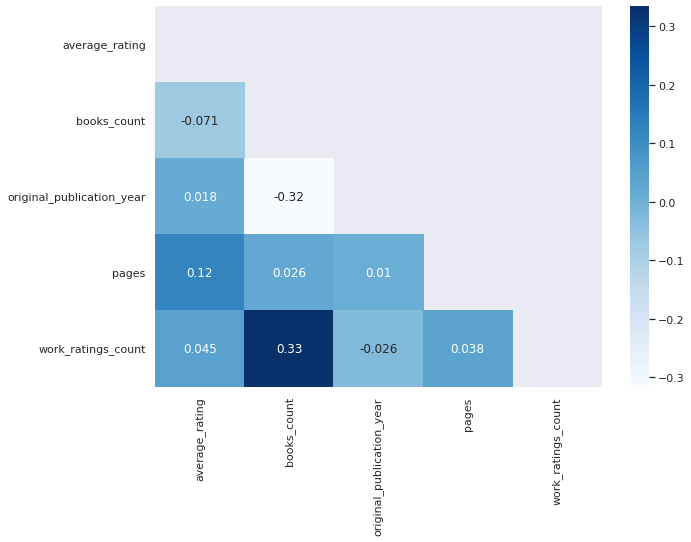

In [ ]:
# first let's check correlation
import matplotlib.pyplot as plt
import seaborn as sns

#build correlation table
numerical_cols=["average_rating",'books_count',"original_publication_year","pages","work_ratings_count"]
corr = books_df[numerical_cols].corr()

#heatmap
upper_triangle= np.triu(corr)
plt.figure(figsize=(10,7))
sns.set(rc={'figure.figsize':(25,20)})
sns.heatmap(corr, annot=True, cmap="Blues", mask=upper_triangle);

# Modeling

## Data preparation and sampling

In [ ]:
# save book ids and titles to use later 
titles_df = books_df[['book_id','title']].set_index('book_id')

# filter columns that will be used for regression
regression_columns = ["book_id", "books_count", "original_publication_year", "pages", "work_ratings_count", "genres"]
books_df_reg = books_df[regression_columns]

#sample users with 130+ reviews only
ratings_sampled_2 = ratings_sampled.loc[ratings_sampled.groupby("user_id")['rating'].transform(func='count')>130,:]

## Importing the wishlist

In [ ]:
# Data wrangling for validation. We are using only the sampled users with 130+ reviews.

#import user wishlists
toread_df = pd.read_csv('https://drive.google.com/uc?id=12vs0eBrFRnX3UOFpIQh0Yv-pjnOLhJ1e')

#remove books that are not in the books dataset (book_id in features)
book_list=books_df_reg['book_id'].tolist()
toread_df = toread_df[toread_df['book_id'].isin(book_list)]

#compile list of wishlist books per user in a comma separated list
toread_df = toread_df.groupby('user_id')['book_id'].apply(list).reset_index(name='wishlist')

#retain only users present in the regression training set
#first, sort values by ascending users and descending ratings
sampled_ratings_ordered=ratings_sampled_2.sort_values(['user_id', 'rating'], ascending=[True, False])
#in the sampled dataset, agregate read books per user. They are already ordered by rating : highest to lowest
sampled_ratings_books=sampled_ratings_ordered.groupby('user_id')['book_id'].apply(list).reset_index(name='read_books')
#in the sampled dataset, agregate ratings in a list per user.
sampled_ratings_ordered=sampled_ratings_ordered.groupby('user_id')['rating'].apply(list).reset_index(name='ratings')

#merge these columns together
sampled_ratings_ordered = sampled_ratings_ordered.merge(sampled_ratings_books, how="inner", on="user_id")

#merge them with the wishlist df
evaluation_df = toread_df.merge(sampled_ratings_ordered, how="inner", on="user_id")

#add the average rating column and drop unneeded columns
evaluation_df = evaluation_df.merge(av_rating_user,how="inner", on="user_id")
evaluation_df= evaluation_df.rename(columns={"book_id":"wishlist_book_id", "rating":"average_rating"})

evaluation_df.shape

(1025, 5)

In [ ]:
evaluation_df.head()

,user_id,wishlist,ratings,read_books,average_rating
0,35,"[198, 139]","[5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[137, 4148, 80, 63, 42, 516, 171, 255, 117, 17...",3.113636
1,146,"[3024, 408, 6620, 217, 8547, 2524, 522, 385, 1...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[887, 354, 184, 178, 516, 4, 2750, 306, 1373, ...",3.597222
2,220,"[426, 4079, 5341, 241, 592, 758, 2841, 3933, 2...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, ...","[191, 4510, 492, 1199, 297, 70, 135, 9037, 407...",3.395522
3,368,"[2079, 2757, 8007, 2496, 1334, 867, 194]","[5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, ...","[7401, 1136, 150, 461, 779, 2314, 124, 16, 355...",3.123596
4,377,"[2917, 6917, 437, 2906, 2307, 2723, 6737, 3228]","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[1145, 407, 100, 2124, 196, 815, 181, 7, 2, 16...",4.062069


In [ ]:
#how many books do users have in their wishlist ?
from statistics import mean
print(mean([len(row) for row in evaluation_df['wishlist']]))

#how many unique books do we have in our training set ?
num_books_training = len(books_df_reg)

#what is the coverage of books in the wishlist ?
import numpy as np
unique_wishlist_books = len(np.unique(np.concatenate([row for row in evaluation_df['wishlist']])))
print(unique_wishlist_books/num_books_training)

13.284878048780488
0.4680145152928979


## Linear Regression

In [ ]:
# create dummies for genres (that are encoded as lists)
dummies_genres = pd.get_dummies(books_df_reg["genres"].explode()).sum(level=0)
books_df_reg = pd.merge(books_df_reg,dummies_genres, left_index=True, right_index=True).drop(columns=["genres"])

#drop NaN values
books_df_reg = books_df_reg.dropna()

In [ ]:
# merge book and re-sampled ratings
df_reg = pd.merge(ratings_sampled_2,books_df_reg,left_on="book_id", right_on="book_id")
df_reg.head(5)

# drop users that are not in wishlist (we want to have 1025 users only)
user_list=toread_df['user_id'].unique()
df_reg = df_reg[df_reg['user_id'].isin(user_list)]

In [ ]:
# Feature engineering

# Add a user's average ratings and average number of pages reads
def create_mean_stats(df,cols):
  for i in cols:
    df.loc[:,i+str("_user_mean")] = df.groupby("user_id")[i].transform(func='mean')
  return(df)

df_reg = create_mean_stats(df_reg, ['rating', 'pages'])

# Add tags for genre occurence amongst all of a user's review
def create_perc_tag(df, cols):
  for i in cols: 
    sum_tags = df.groupby("user_id")[i].transform(func='sum')
    num_reviews = df.groupby("user_id")['book_id'].transform(func='count')
    df.loc[:,i+str("_perc_read")] = sum_tags/num_reviews
  return(df)

df_reg = create_perc_tag(df_reg, dummies_genres.columns)

# Create interactions between certain columns
from sklearn.preprocessing import PolynomialFeatures

def create_interactions(df, cols): 
  poly = PolynomialFeatures(interaction_only=True, include_bias=False)

  df = df.reset_index(drop=True)
  interaction_df_in = df.loc[:,cols]
  interaction_df_out = poly.fit_transform(interaction_df_in)
  interaction_cols = poly.get_feature_names_out(interaction_df_in.columns)
  interaction_df_out = pd.DataFrame(interaction_df_out, columns=interaction_cols)
  df = pd.concat([df, interaction_df_out.iloc[:,len(cols):]],axis=1)
  return(df,interaction_cols)

df_reg,interaction_cols = create_interactions(df_reg, ['pages','original_publication_year',"rating_user_mean", "pages_user_mean"])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# scale interaction columns + other numericals columns (on a 0 to 1 scale)
from sklearn.preprocessing import MinMaxScaler

def scale_columns(df,cols):
  scaler = MinMaxScaler()
  scale_cols = (interaction_cols.tolist()+cols)
  df[scale_cols] = scaler.fit_transform(df[scale_cols])
  return(df)

df_reg = scale_columns(df_reg,["books_count", "work_ratings_count", "pages", "original_publication_year"])

In [ ]:
#create dummies for users and books, reset index
dummy_cols = ['user_id',"book_id"]
df_reg_final = pd.get_dummies(df_reg, columns=dummy_cols, sparse=True)
df_reg_final.reset_index(drop=True, inplace=True)

In [ ]:
# convert to sparse array (csr is type best suited for row wise operations)
#see explanation of sparse data structures : https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067
# https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
from scipy.sparse import csr_matrix

y = df_reg_final["rating"]
X = df_reg_final.drop("rating",1)
X_sparse = csr_matrix(X.astype(pd.SparseDtype("float",0)).sparse.to_coo())

# count sparsity (amount of 0s in sparse matrix)
sparsity = 1 - (X_sparse.count_nonzero() /(X.shape[0]*X.shape[1]))
print(f"Sparsity:{round(sparsity*100,2)}%")

Sparsity:99.51%


In [ ]:
#Train test split
from sklearn.model_selection import train_test_split

# Split 
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y,test_size=0.2, random_state=1234, shuffle=True)

In [ ]:
df_reg.head()

,user_id,book_id,rating,books_count,original_publication_year,pages,work_ratings_count,art,biography,books,business,chick-lit,christian,classics,comics,contemporary,cookbooks,crime,fantasy,fiction,gay-and-lesbian,graphic-novels,historical-fiction,history,horror,humor-and-comedy,manga,memoir,music,mystery,nonfiction,paranormal,philosophy,poetry,psychology,religion,romance,science,science-fiction,self-help,...,christian_perc_read,classics_perc_read,comics_perc_read,contemporary_perc_read,cookbooks_perc_read,crime_perc_read,fantasy_perc_read,fiction_perc_read,gay-and-lesbian_perc_read,graphic-novels_perc_read,historical-fiction_perc_read,history_perc_read,horror_perc_read,humor-and-comedy_perc_read,manga_perc_read,memoir_perc_read,music_perc_read,mystery_perc_read,nonfiction_perc_read,paranormal_perc_read,philosophy_perc_read,poetry_perc_read,psychology_perc_read,religion_perc_read,romance_perc_read,science_perc_read,science-fiction_perc_read,self-help_perc_read,spirituality_perc_read,sports_perc_read,suspense_perc_read,thriller_perc_read,travel_perc_read,young-adult_perc_read,pages original_publication_year,pages rating_user_mean,pages pages_user_mean,original_publication_year rating_user_mean,original_publication_year pages_user_mean,rating_user_mean pages_user_mean
0,220,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.007576,0.333333,0.204545,0.212121,0.000000,0.098485,0.522727,0.848485,0.000000,0.204545,0.113636,0.083333,0.159091,0.007576,0.022727,0.113636,0.015152,0.136364,0.174242,0.022727,0.053030,0.022727,0.045455,0.053030,0.060606,0.060606,0.356061,0.037879,0.015152,0.000000,0.106061,0.181818,0.053030,0.219697,0.173207,0.059606,0.045793,0.817629,0.731388,0.371885
1,1532,191,2,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.636364,0.015152,0.265152,0.000000,0.083333,0.265152,0.886364,0.000000,0.022727,0.393939,0.060606,0.075758,0.000000,0.000000,0.090909,0.007576,0.106061,0.113636,0.053030,0.075758,0.083333,0.060606,0.037879,0.212121,0.022727,0.113636,0.030303,0.045455,0.007576,0.037879,0.068182,0.060606,0.265152,0.173207,0.068941,0.040373,0.875228,0.689891,0.382935
2,4589,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.220472,0.165354,0.488189,0.007874,0.070866,0.362205,0.929134,0.007874,0.165354,0.259843,0.062992,0.118110,0.000000,0.047244,0.062992,0.039370,0.165354,0.086614,0.078740,0.023622,0.007874,0.015748,0.023622,0.299213,0.015748,0.173228,0.015748,0.007874,0.007874,0.039370,0.078740,0.039370,0.102362,0.173207,0.067358,0.046770,0.865464,0.738870,0.458365
3,2694,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.161972,0.049296,0.323944,0.000000,0.176056,0.457746,0.957746,0.000000,0.056338,0.246479,0.042254,0.056338,0.000000,0.000000,0.035211,0.014085,0.338028,0.042254,0.140845,0.014085,0.000000,0.007042,0.007042,0.429577,0.007042,0.119718,0.000000,0.000000,0.000000,0.140845,0.161972,0.035211,0.443662,0.173207,0.065201,0.055666,0.852154,0.806976,0.556830
4,656,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.410853,0.046512,0.325581,0.023256,0.031008,0.240310,0.689922,0.000000,0.038760,0.341085,0.217054,0.031008,0.000000,0.000000,0.209302,0.007752,0.062016,0.325581,0.000000,0.054264,0.000000,0.054264,0.031008,0.131783,0.116279,0.116279,0.046512,0.015504,0.031008,0.007752,0.015504,0.116279,0.170543,0.173207,0.069589,0.049049,0.879227,0.756316,0.512392


## Simple recommender

In [ ]:
# Check accuracy of predicting with the mean
from sklearn.metrics import mean_squared_error, accuracy_score

train_error = mean_squared_error(y_train,np.full_like(y_train, y_train.mean()))
test_error = mean_squared_error(y_test,np.full_like(y_test, y_train.mean()))

print("Constant predictor:")
print(f"Train mean-squared error:{round(train_error,3)}")
print(f"Test mean-squared error:{round(test_error,3)}")

Constant predictor:
Train mean-squared error:1.745
Test mean-squared error:1.742


## Linear regression

In [ ]:
# Initialize regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression(n_jobs=-1)

#Train model on training data
reg.fit(X_train, y_train)

print("Number of parameters: ", reg.coef_.shape[0]+1)

Number of parameters:  9959


In [ ]:
# Regression predictions

## Make train and test predictions
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

## Store MSEs
train_mse_reg = mean_squared_error(y_train, y_train_pred)
test_mse_reg = mean_squared_error(y_test, y_test_pred)

## Print result
print(f"Train Mean squared error:{round(train_mse_reg,3)}")
print(f"Test Mean squared error:{round(test_mse_reg,3):.1f}")

Train Mean squared error:0.667
Test Mean squared error:0.8


In [ ]:
# Feature importance for linear regression : get coefficients in order of importance
regcoefs_sorted = reg.coef_.argsort()[::-1]

#top 5 coefs
top_10 = regcoefs_sorted[:5]

# get feature names
for i in top_10:  
  print(X.columns[i])

rating_user_mean
book_id_8259
book_id_9917
pages pages_user_mean
book_id_8488


## Predicting ratings for a user's unread books.

This section is tricky because we have to adjust an input matrix that has exactly the same number of columns as the trained model.

In [ ]:
# Contructing a new input matrix based on the books a random user has not yet read

#suppress copy warning
pd.set_option('mode.chained_assignment',None)

books_df_np=books_df_reg.to_numpy()
books_df_columns=books_df_reg.columns

def construct_new_matrix(id):
  #find ratings associated to that id
  user = ratings_sampled_2[ratings_sampled_2['user_id'] == id]

  #merge with book info (scaled, before user and book dummies)
  user = pd.merge(user, books_df_reg, on="book_id")

  #number of columns in user
  user_cols=user.shape[1]

  #add features
  user = create_mean_stats(user, ['rating', 'pages'])
  user = create_perc_tag(user, dummies_genres.columns)

  #find books not read by that user
  unread = books_df_reg[~books_df_reg['book_id'].isin(user['book_id'])]

  #add in features to the list of unread books
  user_values = user.iloc[1,46:]
  for i,v in user_values.items():
      unread.loc[:,i]=v

  #add user-id column
  unread['user_id']=id

  #interactions
  unread, cols = create_interactions(unread, ['original_publication_year','pages',"rating_user_mean", "pages_user_mean"])

  #add dummies for book_id
  to_predict = pd.get_dummies(unread, columns=["book_id"])

  #readjust the columns so that they correspond to those in the training set (fill with 0 if absent)
  to_predict = to_predict.reindex(labels = df_reg_final.columns, axis = 1, fill_value=0)
  to_predict.drop(columns="rating", inplace=True)

  #scale
  scale_columns(to_predict,["books_count", "work_ratings_count", "pages", "original_publication_year"])

  #assign a value of 1 to for the dummy linked to that user
  to_predict[str('user_id_'+str(id))]=1

  return(to_predict, unread)

#sample user id
id = ratings_sampled_2['user_id'].sample(random_state = 123).values[0]

new_user,unread = construct_new_matrix(id)

new_user.head(5)
unread.head(5)

,book_id,books_count,original_publication_year,pages,work_ratings_count,art,biography,books,business,chick-lit,christian,classics,comics,contemporary,cookbooks,crime,fantasy,fiction,gay-and-lesbian,graphic-novels,historical-fiction,history,horror,humor-and-comedy,manga,memoir,music,mystery,nonfiction,paranormal,philosophy,poetry,psychology,religion,romance,science,science-fiction,self-help,spirituality,sports,...,classics_perc_read,comics_perc_read,contemporary_perc_read,cookbooks_perc_read,crime_perc_read,fantasy_perc_read,fiction_perc_read,gay-and-lesbian_perc_read,graphic-novels_perc_read,historical-fiction_perc_read,history_perc_read,horror_perc_read,humor-and-comedy_perc_read,manga_perc_read,memoir_perc_read,music_perc_read,mystery_perc_read,nonfiction_perc_read,paranormal_perc_read,philosophy_perc_read,poetry_perc_read,psychology_perc_read,religion_perc_read,romance_perc_read,science_perc_read,science-fiction_perc_read,self-help_perc_read,spirituality_perc_read,sports_perc_read,suspense_perc_read,thriller_perc_read,travel_perc_read,young-adult_perc_read,user_id,original_publication_year pages,original_publication_year rating_user_mean,original_publication_year pages_user_mean,pages rating_user_mean,pages pages_user_mean,rating_user_mean pages_user_mean
0,1,272,2008.0,374.0,4942365,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0.095238,0.0,0.303571,0.0,0.035714,0.684524,0.982143,0.0,0.0,0.142857,0.011905,0.059524,0.0,0.0,0.0,0.011905,0.208333,0.0,0.297619,0.005952,0.0,0.017857,0.017857,0.642857,0.0,0.238095,0.005952,0.005952,0.0,0.029762,0.065476,0.017857,0.827381,34703,750992.0,6872.619048,834180.571429,1280.059524,155370.285714,1421.853741
1,2,491,1997.0,309.0,4800065,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.095238,0.0,0.303571,0.0,0.035714,0.684524,0.982143,0.0,0.0,0.142857,0.011905,0.059524,0.0,0.0,0.0,0.011905,0.208333,0.0,0.297619,0.005952,0.0,0.017857,0.017857,0.642857,0.0,0.238095,0.005952,0.005952,0.0,0.029762,0.065476,0.017857,0.827381,34703,617073.0,6834.970238,829610.857143,1057.589286,128367.428571,1421.853741
2,4,487,1960.0,324.0,3340896,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.095238,0.0,0.303571,0.0,0.035714,0.684524,0.982143,0.0,0.0,0.142857,0.011905,0.059524,0.0,0.0,0.0,0.011905,0.208333,0.0,0.297619,0.005952,0.0,0.017857,0.017857,0.642857,0.0,0.238095,0.005952,0.005952,0.0,0.029762,0.065476,0.017857,0.827381,34703,635040.0,6708.333333,814240.000000,1108.928571,134598.857143,1421.853741
3,5,1356,1925.0,200.0,2773745,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0.095238,0.0,0.303571,0.0,0.035714,0.684524,0.982143,0.0,0.0,0.142857,0.011905,0.059524,0.0,0.0,0.0,0.011905,0.208333,0.0,0.297619,0.005952,0.0,0.017857,0.017857,0.642857,0.0,0.238095,0.005952,0.005952,0.0,0.029762,0.065476,0.017857,0.827381,34703,385000.0,6588.541667,799700.000000,684.523810,83085.714286,1421.853741
4,7,969,1937.0,366.0,2196809,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.095238,0.0,0.303571,0.0,0.035714,0.684524,0.982143,0.0,0.0,0.142857,0.011905,0.059524,0.0,0.0,0.0,0.011905,0.208333,0.0,0.297619,0.005952,0.0,0.017857,0.017857,0.642857,0.0,0.238095,0.005952,0.005952,0.0,0.029762,0.065476,0.017857,0.827381,34703,708942.0,6629.613095,804685.142857,1252.678571,152046.857143,1421.853741


In [ ]:
#predict with the new input dataframe created above

def predict_new(x, num_books=10, book_ids=False):
  new=reg.predict(x)  
  #add predictings rating to df of unread books (pre-dummies)
  top_books=unread.copy()
  top_books.loc[:,'pred_rating']=new
  #sort by rating 
  top_books = top_books.sort_values("pred_rating", ascending = False)
  #get top book ids
  top_books = top_books.iloc[0:num_books][["pred_rating", "book_id"]]
  if book_ids==True:
    return(top_books['book_id'].to_list())
  else:
    #add title
    results = pd.merge(top_books, titles_df, on="book_id")
    return(results)

predict_new(new_user, num_books=10, book_ids=False)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



,pred_rating,book_id,title
0,4.726835,8259,Graffiti World: Street Art from Five Continents
1,4.273918,9243,A Little History of the World
2,4.244742,8548,This is Not My Hat
3,4.196151,7365,The Peripheral
4,4.146428,9917,Such a Rush
5,4.089829,6714,In the Kingdom of Ice: The Grand and Terrible ...
6,4.086867,7228,In the Shadow of the Banyan
7,4.086243,6419,"Sex Criminals, Vol. 1: One Weird Trick"
8,4.085590,8077,"The Walking Dead, Vol. 14: No Way Out"
9,4.073774,8232,How Soccer Explains the World


##Evaluating basic linear regression

In [ ]:
def basic_lin_evaluation(df=evaluation_df, recommend_num=5):

  #get predictions
  df=df.copy()
  predicted_books = predict_new(new_user, num_books=30, book_ids=True)
  df['recommendations'] = [predicted_books for _ in range(len(df))]
  
  #find intersections between the wishlist and the recommendations
  df['recommendations'] = [(set(a)-set(b)) for a, b in zip(df['read_books'], df['recommendations'])]
  df['recommendations']= [list(row) for row in df['recommendations']]

  #select top x predictions
  df['recommendations']=[row[0:recommend_num] for row in df['recommendations']]

  #find intersections between the wishlist and the recommendations
  true_pos = [len(set(a) & set(b)) for a, b in zip(df['wishlist'], df['recommendations'])]

  #calculate scores  
  df['true_pos']=true_pos
  df['precision']=df['true_pos']/recommend_num
  df['true_pos_binary']=np.where(df['true_pos']>0,1,0)
  df['recall']=df['true_pos']/len(df['wishlist'])

  #averages
  average_tp = round((df['true_pos'].sum()/len(df))*100,2)
  average_precision=round((df['precision'].sum()/len(df))*100,2)
  average_binary_tp=round((df['true_pos_binary'].sum()/len(df))*100,2)
  average_recall=round((df['recall'].sum()/len(df))*100,5)
  coverage=len(np.unique(np.concatenate([row for row in df['recommendations']])))/len(books_df_reg)
  coverage=round(coverage*100,2)

  print(f'Recommend {recommend_num} books with linear reg: \n Coverage : {coverage}% \n Average true positives : {average_tp}% \n Average precision : {average_precision}% \n Average recall : {average_recall}% \n Average Binary TPs : {average_binary_tp}%')

In [ ]:
basic_lin_evaluation(df=evaluation_df, recommend_num=10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



Recommend 10 books with linear reg: 
 Coverage : 6.73% 
 Average true positives : 0.1% 
 Average precision : 0.01% 
 Average recall : 0.0001% 
 Average Binary TPs : 0.1%


## Tweaking the model

**Problem with linear regression.** 

Even with interactions, the predictions for different users are almost always the same. The trained model mostly relies on the ids of very popular (well-rated) books to predict ratings. We decided to build a ratio to adjust predicted ratings by the probability a user would genre the genres present in a book.

In [ ]:
#Improving the recommender : scaling scores by the user's genre preference. 
# the predicted ratings are adjusted according to the genres the users read most

def better_recommender(new_user_matrix, return_ids=False, num_recos=10):
  new_user=unread.copy()
  new_user['rating_pred']=reg.predict(new_user_matrix)
  new_user['perc_all_sum']=0
  new_user['perc_present_sum']=0
  genre_columns=dummies_genres.columns.to_list()
  for genre in genre_columns:
    new_user['perc_all_sum'] = new_user['perc_all_sum']+new_user[genre+'_perc_read']
    new_user['perc_present_sum'] = new_user['perc_present_sum']+(new_user[genre+'_perc_read']*new_user[genre])
    new_user['perc_missing_sum']=new_user['perc_all_sum']-new_user['perc_present_sum']
  new_user['ratio']=new_user['perc_present_sum']/new_user['perc_missing_sum']
  new_user['rating_new']=new_user['rating_pred']*new_user['ratio']
  new_user.sort_values('rating_new',ascending=False, inplace=True)
  top_books = new_user.iloc[0:num_recos][['rating_new','book_id']]
  results = pd.merge(top_books, titles_df, on="book_id")
  if return_ids==True:
    return(results['book_id'].tolist())
  else:
    return(results) #return new_user

better_recommender(new_user, return_ids=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



[652, 4470, 9166, 6538, 7691, 5837, 6433, 1948, 5023, 4267]

#Evaluating tweaked linear regression

In [ ]:
#predict for every user

lin_recs=[]
for user_id in evaluation_df['user_id']:
  new_user,unread = construct_new_matrix(user_id)
  new_user=new_user.to_numpy()
  result = better_recommender(new_user, return_ids=True, num_recos=25)
  lin_recs.append(result)

In [ ]:
#evaluate

def tweaked_lin_evaluation(predictions, evaluation_df, recommend_num):
  #linear reg copy
  df=evaluation_df.copy()
  lin_recs_2=lin_recs.copy()

  #add predictions
  df['recommendations']=predictions

  #trim to 10 books
  df['recommendations']=[row[0:10] for row in df['recommendations']]

  #find intersections between the wishlist and the recommendations
  true_pos = [len(set(a) & set(b)) for a, b in zip(df['wishlist'], df['recommendations'])]

  #calculate scores  
  df['true_pos']=true_pos
  df['precision']=df['true_pos']/recommend_num
  df['true_pos_binary']=np.where(df['true_pos']>0,1,0)
  df['recall']=df['true_pos']/len(df['wishlist'])

  #averages
  average_tp = round((df['true_pos'].sum()/len(df))*100,2)
  average_precision=round((df['precision'].sum()/len(df))*100,2)
  average_binary_tp=round((df['true_pos_binary'].sum()/len(df))*100,2)
  average_recall=round((df['recall'].sum()/len(df))*100,5)
  coverage=len(np.unique(np.concatenate([row for row in df['recommendations']])))/len(books_df_reg)
  coverage=round(coverage*100,2)

  print(f'Recommend {recommend_num} books with tweaked linear regression: \n Coverage : {coverage}% \n Average true positives : {average_tp}% \n Average precision : {average_precision}% \n Average recall : {average_recall}% \n Average Binary TPs : {average_binary_tp}%')

In [ ]:
tweaked_lin_evaluation(predictions=lin_recs, evaluation_df=evaluation_df, recommend_num=10)

Recommend 10 books with tweaked linear regression: 
 Coverage : 2.48% 
 Average true positives : 4.1% 
 Average precision : 0.41% 
 Average recall : 0.004% 
 Average Binary TPs : 3.9%


# Baseline: popular recommender

In [ ]:
#start with sampled df from linear regression
df = df_reg.iloc[:,0:3]
df_pop = df.groupby('book_id')['rating'].mean().reset_index()
df_pop.head()

,book_id,rating
0,1,4.295720
1,2,4.369892
2,3,3.090426
3,4,4.361842
4,5,3.781863


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17a44e3610>]],
      dtype=object)

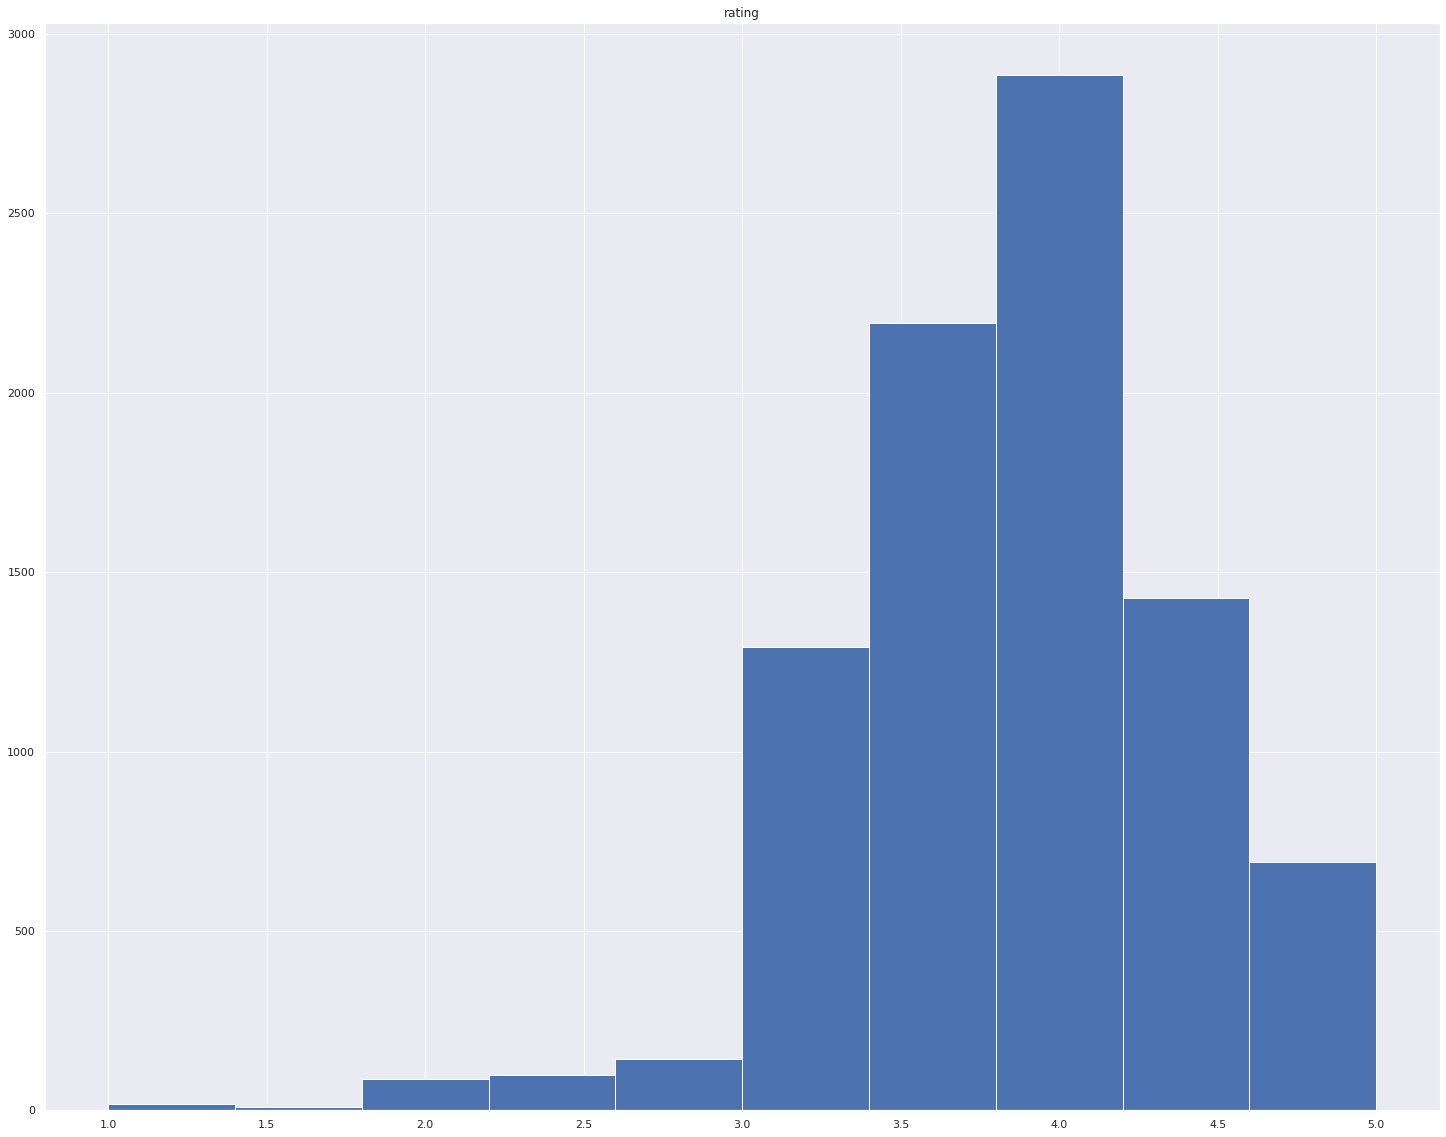

In [ ]:
df_pop = df_pop.sort_values('rating',ascending=False)
df_pop.hist('rating')
# over 500 books have 5 stars ratings

In [ ]:
# pick out the most popular 100 books and merge them into a list
pop_100 = df_pop['book_id'][0:100]
pop_100 = [row for row in pop_100]

In [ ]:
# add these 100 books to the evaluation dataset
evaluation_pop=evaluation_df.copy()
evaluation_pop['recommendations']= [pop_100 for i in evaluation_pop.index]

In [ ]:
# we want the 'recommend_num' (default is 5) books that are in pop100 but not in book_id
def recommend_pop(list1, list2, recommend_num=5):
  recommend_whole_list = list(set(list1)-set(list2))
  return (list(set(list1)-set(list2))[0:recommend_num])

In [ ]:
def pop_evaluation(df, recommend_num=5):
  
  # get recommend popular books for each user
  df['recommendations'] = df.apply(lambda x: recommend_pop(x['recommendations'],x['read_books'],recommend_num),axis=1)

  #find intersections between the wishlist and the recommendations
  true_pos = [len(set(a) & set(b)) for a, b in zip(df['wishlist'], df['recommendations'])]

  #concat interesections to df
  
  df['true_pos']=true_pos
  df['precision']=df['true_pos']/recommend_num
  df['true_pos_binary']=np.where(df['true_pos']>0,1,0)
  df['recall']=df['true_pos']/len(df['wishlist'])

  #averages
  average_tp = round((df['true_pos'].sum()/len(df))*100,2)
  average_precision=round((df['precision'].sum()/len(df))*100,2)
  average_binary_tp=round((df['true_pos_binary'].sum()/len(df))*100,2)
  average_recall=round((df['recall'].sum()/len(df))*100,5)
  coverage=len(np.unique(np.concatenate([row for row in df['recommendations']])))/len(books_df_reg)
  coverage=round(coverage*100,2)

  print(f'Recommend {recommend_num} popular books: \n Coverage : {coverage}% \n Average true positives : {average_tp}% \n Average precision : {average_precision}% \n Average recall : {average_recall}% \n Average Binary TPs : {average_binary_tp}%')

In [ ]:
#run evaluation function
pop_evaluation(df = evaluation_pop,recommend_num = 10)

Recommend 10 popular books: 
 Coverage : 0.12% 
 Average true positives : 0.2% 
 Average precision : 0.02% 
 Average recall : 0.00019% 
 Average Binary TPs : 0.2%


# Content-based filtering

In [ ]:
#build dataset of features
features = books_df[["book_id","authors","original_publication_year","genres","title","description"]]
features = features.astype(str)
features.shape
features['content'] = features['authors'] + ' '  + features['genres'] + ' '  + features['description']
features = features.reset_index()
indices = pd.Series(features.index, index=features['title'])

features["book_id"] = features["book_id"].astype(str).astype(int)
features["title"] = features["title"].astype(str)

features.shape

#select only books which are in linear regression dataset
#features = features[features['book_id'].isin(df_reg['book_id'].unique())]

(9645, 8)

In [ ]:
#feature representation with tf-idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfv = TfidfVectorizer(stop_words={'english'})
tf_matrix = tfv.fit_transform(features["content"])
tf_matrix.shape

(9645, 52412)

In [ ]:
#compute distances 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

#euclidian distance
euc_distance = euclidean_distances(tf_matrix,tf_matrix)
#cosine distance
cos_distance = cosine_similarity(tf_matrix,tf_matrix)


In [ ]:
def get_recommendations(title, distance_metric=cos_distance, num_books=10, book_id=False):
    idx = indices[title] 

    # Get the pairwise similarity scores using the specified distance
    sim_scores = list(enumerate(distance_metric[idx]))

    # Sort the list of indices and scores by descending similarity scores
    sim_scores = sorted(sim_scores, key=lambda tup: tup[1], reverse=True)

    # Get the scores of the 10 most similar books (change this back to 301?)
    sim_scores = sim_scores[1:num_books]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    if book_id==True:
    # Return the top 10 most similar books
      return list(features['book_id'].iloc[book_indices])

    else:
      return list(features['title'].iloc[book_indices])

In [ ]:
random_book = indices.sample().index[0]
print(random_book)
get_recommendations("The Great Dune Trilogy  ", distance_metric=cos_distance)

Freckle Juice


['Hunters of Dune (Dune Chronicles #7)',
 'Chapterhouse: Dune (Dune Chronicles #6)',
 'The Butlerian Jihad (Legends of Dune, #1)',
 'Heretics of Dune (Dune Chronicles #5)',
 'House Atreides (Prelude to Dune #1)',
 'The Machine Crusade (Legends of Dune, #2)',
 'House Corrino (Prelude to Dune #3)',
 'Dune (Dune Chronicles #1)',
 'God Emperor of Dune (Dune Chronicles #4)']

In [ ]:
#create copy
content_evaluation_df=evaluation_df.copy()

#For content based prediction, add each user's top book from the complete ratings df
highest_rating_book = ratings.sort_values(by=["rating"],ascending=False).groupby("user_id").head(1)

#drop columns and rename book_id
highest_rating_book = highest_rating_book.drop(columns=["rating"])
highest_rating_book = highest_rating_book.rename(columns={"book_id":"highest_rated_book"})

#merge the wishlist books with the best rated book for each user
content_evaluation_df = content_evaluation_df.merge(highest_rating_book,"inner","user_id")
content_evaluation_df = content_evaluation_df.rename(columns={"book_id":"wishlist"})

#get title of highest rated book by looking it up in features_df
content_evaluation_df = content_evaluation_df.merge(features[["title","book_id"]],left_on="highest_rated_book",right_on="book_id",how = "inner",validate="many_to_one")
content_evaluation_df = content_evaluation_df.drop(columns=["book_id"])
content_evaluation_df = content_evaluation_df.sort_values("user_id")
content_evaluation_df.reset_index(inplace=True)
content_evaluation_df.head(5)
content_evaluation_df.shape

(1014, 8)

In [ ]:
#function to evaluate content-based recommender

def content_based_evaluation(df, distance_metric,recommend_num=5):
    #empty list to store loop info
    recos=[]
    read_books = df['read_books'].to_numpy()

    #get 25 recommendations for each user
    iterator=0
    for i in df["title"]:
      rec = get_recommendations(i, num_books=25,book_id=True, distance_metric=distance_metric)
      for item in rec:
        if item in read_books[iterator]:
          rec.remove(item)
      rec=rec[0:recommend_num]
      recos.append(rec)
      iterator+=1

    #concat recommendations to df
    df = pd.concat([df, pd.Series(recos, name='recom')], axis=1)

    #find intersections between the wishlist and the recommendations
    true_pos = [len(set(a) & set(b)) for a, b in zip(df['wishlist'], df['recom'])]

    #calculate scores
    df['true_pos']=true_pos
    df['precision']=df['true_pos']/recommend_num
    df['true_pos_binary']=np.where(df['true_pos']>0,1,0)
    df['recall']=df['true_pos']/len(df['wishlist'])

    #averages
    average_tp = round((df['true_pos'].sum()/len(df))*100,2)
    average_precision=round((df['precision'].sum()/len(df))*100,2)
    average_binary_tp=round((df['true_pos_binary'].sum()/len(df))*100,2)
    average_recall=round((df['recall'].sum()/len(df))*100,5)
    coverage=len(np.unique(np.concatenate([row for row in df['recom']])))/len(books_df_reg)
    coverage=round(coverage*100,2)

    print(f'Recommend {recommend_num} similar books (content-based): \n Coverage : {coverage}% \n Average true positives : {average_tp}% \n Average precision : {average_precision}% \n Average recall : {average_recall}% \n Average Binary TPs : {average_binary_tp}%')

In [ ]:
#run function
content_based_evaluation(df=content_evaluation_df, distance_metric=cos_distance, recommend_num=10)

Recommend 10 similar books (content-based): 
 Coverage : 37.39% 
 Average true positives : 6.61% 
 Average precision : 0.66% 
 Average recall : 0.00652% 
 Average Binary TPs : 5.72%


# User-based Collaborative filtering

In [ ]:
#preparing the data
#we will be working with wishlist df already imported above and merge it with the sampled df from linear regression
from scipy import spatial

user_based_eval=evaluation_df.copy()
user_based_eval.head(5)

,user_id,wishlist,ratings,read_books,average_rating
0,35,"[198, 139]","[5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[137, 4148, 80, 63, 42, 516, 171, 255, 117, 17...",3.113636
1,146,"[3024, 408, 6620, 217, 8547, 2524, 522, 385, 1...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[887, 354, 184, 178, 516, 4, 2750, 306, 1373, ...",3.597222
2,220,"[426, 4079, 5341, 241, 592, 758, 2841, 3933, 2...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, ...","[191, 4510, 492, 1199, 297, 70, 135, 9037, 407...",3.395522
3,368,"[2079, 2757, 8007, 2496, 1334, 867, 194]","[5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, ...","[7401, 1136, 150, 461, 779, 2314, 124, 16, 355...",3.123596
4,377,"[2917, 6917, 437, 2906, 2307, 2723, 6737, 3228]","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[1145, 407, 100, 2124, 196, 815, 181, 7, 2, 16...",4.062069


In [ ]:
#convert dataframe to 2d numpy array : speeds up processing
user_based_eval_np = user_based_eval.to_numpy()

In [ ]:
#compute pairwise similarity between every subject (runs in 1.5 mins)
distances=[]

for first_user in range (0,len(user_based_eval_np)):
  for second_user in range(0,len(user_based_eval_np)):
    #store rating average, rated books and ratings for the pair of users
    first_user_average=user_based_eval_np[first_user,4]
    first_user_books=user_based_eval_np[first_user,3]
    first_user_ratings= user_based_eval_np[first_user,2]
    second_user_average=user_based_eval_np[second_user,4]
    second_user_books=user_based_eval_np[second_user,3]
    second_user_ratings= user_based_eval_np[second_user,2]

    #find common books
    common_books = set(first_user_books).intersection(second_user_books)

    #if less than 5 common books, distance is 0
    if len(common_books)<5 :
      distance=0

    else:
      #find index of common_books in each set
      index_user1 = [first_user_books.index(x) for x in common_books]
      index_user2 = [second_user_books.index(x) for x in common_books]

      #get the ratings of these books
      ratings_user1 = [(first_user_ratings[x]/first_user_average) for x in index_user1]
      ratings_user2 = [(second_user_ratings[x]/second_user_average) for x in index_user2]

      #compute the cosine distance between weighed ratings (with each user's average)
      distance = 1-spatial.distance.cosine(ratings_user1,ratings_user2)

    #add the distances to the list 
    distances.append([first_user,second_user,distance])

In [ ]:
#recommender function for user-based filtering

def get_user_recommendations(data, user_id, num_similar=5):

  #get the np index corresponding to that user
  index_user = np.argwhere(data==user_id)[0,0]

  #get this user's rated books
  user_rated_books = data[index_user,3]

  #get similar users  
  similar_users = ([row for row in distances if row[0]==index_user])

  #sort by similarity 
  similar_users = sorted(similar_users, key = lambda x: x[2], reverse=True)

  #get index of top X similar users and exclude the user itself
  top_X_similar = [row[1] for row in similar_users[0:(num_similar)] if row[1]!=index_user]

  #get the first top-rated book for each top 5 similar user, providing it has not yet been read by the original user
  top_recs=[]
  for top in top_X_similar:
    #get rated books 
    top_row = data[top]
    top_book = next(i for i in top_row[3] if i not in user_rated_books)
    top_recs.append(top_book)
  return(top_recs)

#generate random user id from df and get recommendations
random_user = user_based_eval["user_id"].sample().item()
get_user_recommendations(data=user_based_eval_np, user_id=random_user, num_similar=10)

[313, 3188, 210, 1141, 253, 2629, 179, 2857, 10]

In [ ]:
#function to evaluate user-based recommender
def user_based_evaluation(df, data_np, similar_users=5):

  #get recommendations for every user
  total_recommendations=[]

  for user in df['user_id']:
    recs = get_user_recommendations(data=data_np, user_id=user, num_similar=similar_users)
    total_recommendations.append(recs)

  df['user_based_recommendations']=total_recommendations

  #find intersections between the wishlist and the recommendations
  true_pos = [len(set(a) & set(b)) for a, b in zip(df['wishlist'], df['user_based_recommendations'])]

  #calculate scores
  df['true_pos']=true_pos
  df['precision']=df['true_pos']/similar_users
  df['true_pos_binary']=np.where(df['true_pos']>0,1,0)
  df['recall']=df['true_pos']/len(df['wishlist'])

  #averages
  average_tp = round((df['true_pos'].sum()/len(df))*100,2)
  average_precision=round((df['precision'].sum()/len(df))*100,2)
  average_binary_tp=round((df['true_pos_binary'].sum()/len(df))*100,2)
  average_recall=round((df['recall'].sum()/len(df))*100,5)
  coverage=len(np.unique(np.concatenate([row for row in df['user_based_recommendations']])))/len(books_df_reg)
  coverage=round(coverage*100,2)

  print(f'Recommend {similar_users} books (user-based): \n Coverage : {coverage}% \n Average true positives : {average_tp}% \n Average precision : {average_precision}% \n Average recall : {average_recall}% \n Average Binary TPs : {average_binary_tp}%')

In [ ]:
#run evaluation function
user_based_evaluation(df=user_based_eval, data_np=user_based_eval_np, similar_users=10)

Recommend 10 books (user-based): 
 Coverage : 7.64% 
 Average true positives : 8.49% 
 Average precision : 0.85% 
 Average recall : 0.00828% 
 Average Binary TPs : 7.51%


# Neural Network 1 (with PCA)

---



In [ ]:
nn_df = df_reg.copy()
nn_df.head()

,user_id,book_id,rating,books_count,original_publication_year,pages,work_ratings_count,art,biography,books,business,chick-lit,christian,classics,comics,contemporary,cookbooks,crime,fantasy,fiction,gay-and-lesbian,graphic-novels,historical-fiction,history,horror,humor-and-comedy,manga,memoir,music,mystery,nonfiction,paranormal,philosophy,poetry,psychology,religion,romance,science,science-fiction,self-help,...,christian_perc_read,classics_perc_read,comics_perc_read,contemporary_perc_read,cookbooks_perc_read,crime_perc_read,fantasy_perc_read,fiction_perc_read,gay-and-lesbian_perc_read,graphic-novels_perc_read,historical-fiction_perc_read,history_perc_read,horror_perc_read,humor-and-comedy_perc_read,manga_perc_read,memoir_perc_read,music_perc_read,mystery_perc_read,nonfiction_perc_read,paranormal_perc_read,philosophy_perc_read,poetry_perc_read,psychology_perc_read,religion_perc_read,romance_perc_read,science_perc_read,science-fiction_perc_read,self-help_perc_read,spirituality_perc_read,sports_perc_read,suspense_perc_read,thriller_perc_read,travel_perc_read,young-adult_perc_read,pages original_publication_year,pages rating_user_mean,pages pages_user_mean,original_publication_year rating_user_mean,original_publication_year pages_user_mean,rating_user_mean pages_user_mean
0,220,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.007576,0.333333,0.204545,0.212121,0.000000,0.098485,0.522727,0.848485,0.000000,0.204545,0.113636,0.083333,0.159091,0.007576,0.022727,0.113636,0.015152,0.136364,0.174242,0.022727,0.053030,0.022727,0.045455,0.053030,0.060606,0.060606,0.356061,0.037879,0.015152,0.000000,0.106061,0.181818,0.053030,0.219697,0.173207,0.059606,0.045793,0.817629,0.731388,0.371885
1,1532,191,2,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.636364,0.015152,0.265152,0.000000,0.083333,0.265152,0.886364,0.000000,0.022727,0.393939,0.060606,0.075758,0.000000,0.000000,0.090909,0.007576,0.106061,0.113636,0.053030,0.075758,0.083333,0.060606,0.037879,0.212121,0.022727,0.113636,0.030303,0.045455,0.007576,0.037879,0.068182,0.060606,0.265152,0.173207,0.068941,0.040373,0.875228,0.689891,0.382935
2,4589,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.220472,0.165354,0.488189,0.007874,0.070866,0.362205,0.929134,0.007874,0.165354,0.259843,0.062992,0.118110,0.000000,0.047244,0.062992,0.039370,0.165354,0.086614,0.078740,0.023622,0.007874,0.015748,0.023622,0.299213,0.015748,0.173228,0.015748,0.007874,0.007874,0.039370,0.078740,0.039370,0.102362,0.173207,0.067358,0.046770,0.865464,0.738870,0.458365
3,2694,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.161972,0.049296,0.323944,0.000000,0.176056,0.457746,0.957746,0.000000,0.056338,0.246479,0.042254,0.056338,0.000000,0.000000,0.035211,0.014085,0.338028,0.042254,0.140845,0.014085,0.000000,0.007042,0.007042,0.429577,0.007042,0.119718,0.000000,0.000000,0.000000,0.140845,0.161972,0.035211,0.443662,0.173207,0.065201,0.055666,0.852154,0.806976,0.556830
4,656,191,5,0.025767,0.992036,0.079755,0.081644,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0.410853,0.046512,0.325581,0.023256,0.031008,0.240310,0.689922,0.000000,0.038760,0.341085,0.217054,0.031008,0.000000,0.000000,0.209302,0.007752,0.062016,0.325581,0.000000,0.054264,0.000000,0.054264,0.031008,0.131783,0.116279,0.116279,0.046512,0.015504,0.031008,0.007752,0.015504,0.116279,0.170543,0.173207,0.069589,0.049049,0.879227,0.756316,0.512392


In [ ]:
nn_data = evaluation_df.copy()

# filter out the users with less than 5 books in wishlist
nn_data['operator'] = nn_data['wishlist'].apply(lambda x: 1 if len(x)>=5 else 0)
nn_data = nn_data[nn_data['operator']==1]
nn_data = nn_data.drop(columns=['operator','ratings','read_books']) 

# trim wishlist to only 5 books
nn_data['wishlist'] = nn_data['wishlist'].apply(lambda x: x[0:5])

# for each user, randomly select 5 books that are not in the wishlist
import random
random.seed(123)

def get_unwish_books(row):
  list1 = books_df_reg['book_id'].tolist()
  list2 = row
  unwish_books = list(set(list1)-set(list2))
  sample_unwish_books = random.sample(unwish_books,5)
  return sample_unwish_books

nn_data['unwish'] = nn_data['wishlist'].apply(lambda x: get_unwish_books(x))
nn_unwish = nn_data[['user_id','unwish']]
nn_data = nn_data.drop(columns='unwish')

# # split wishlist books and unwish books into rows
def split_row(data, column):
  row_len = list(map(len,data[column].values))
  rows = []
  for i in data.columns:
    if i == column:
      row = np.concatenate(data[i].values)
    else:
      row = np.repeat(data[i].values, row_len)
    rows.append(row)
  
  return pd.DataFrame(np.dstack(tuple(rows))[0], columns = data.columns)

nn_data = split_row(nn_data, 'wishlist')
nn_data['y'] = 1
nn_unwish = split_row(nn_unwish,'unwish')
nn_unwish['y'] = 0
nn_unwish['average_rating'] = nn_data['average_rating']
nn_data=nn_data.rename(columns={"wishlist":"book_id"})
nn_unwish=nn_unwish.rename(columns={"unwish":"book_id"})

nn_data_new = pd.concat([nn_data, nn_unwish],ignore_index=True)

nn_data_new = nn_data_new.merge(features, left_on='book_id',right_on='book_id')
nn_data_new = nn_data_new.drop(columns=["original_publication_year","index","authors","genres","content"])

nn_genre_pref = nn_df[['user_id','pages_user_mean','original_publication_year','classics_perc_read','fiction_perc_read','romance_perc_read','young-adult_perc_read']]
nn_genre_pref = nn_genre_pref.drop_duplicates(subset = ['user_id'])
nn_data_new = nn_data_new.merge(nn_genre_pref, left_on='user_id',right_on='user_id')

nn_book_page = nn_df[['book_id','pages']]
nn_book_page = nn_book_page.drop_duplicates(subset=['book_id'])
nn_data_new = nn_data_new.merge(nn_book_page, left_on='book_id',right_on='book_id')


nn_data_new = nn_data_new.sort_values(by='user_id',ascending=True,ignore_index=True)
nn_data_new = nn_data_new.drop(columns=['user_id','description'])

In [ ]:
#feature representation with tf-idf
!pip install texthero
import texthero as hero

nn_data_new["vectorized_title"] = (
   nn_data_new['title']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
nn_data_new.head()

     |████████████████████████████████| 235 kB 44.5 MB/s 
     |████████████████████████████████| 1.5 MB 47.8 MB/s 
     |████████████████████████████████| 749 kB 45.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,book_id,average_rating,y,title,pages_user_mean,original_publication_year,classics_perc_read,fiction_perc_read,romance_perc_read,young-adult_perc_read,pages,vectorized_title
0,3024.0,3.597222,1,Desert Solitaire,0.455022,0.994691,0.401408,0.816901,0.147887,0.161972,0.064609,"[-0.00715591421158048, -0.009142364917997229]"
1,4494.0,3.597222,0,"Y: The Last Man, Vol. 8: Kimono Dragons (Y: Th...",0.455022,0.994691,0.401408,0.816901,0.147887,0.161972,0.027607,"[-0.00708606701914422, -0.023654738129851853]"
2,4514.0,3.597222,0,"Vampire Mountain (Cirque Du Freak, #4)",0.455022,0.994691,0.401408,0.816901,0.147887,0.161972,0.039877,"[-0.00962309198738706, -0.017641928976434473]"
3,6914.0,3.597222,0,The House of Thunder,0.455022,0.994691,0.401408,0.816901,0.147887,0.161972,0.069018,"[0.09632317396626687, -0.004512957956229104]"
4,868.0,3.597222,0,Pippi Longstocking,0.455022,0.994691,0.401408,0.816901,0.147887,0.161972,0.030675,"[-0.006862534220839014, -0.00893619259921131]"


In [ ]:
y=nn_data_new['y']
nn_data_new.drop(columns=["title",'y'], inplace=True)

In [ ]:
from copy import deepcopy

# define function to split lists into columns
def split_col(data, column):
  data = deepcopy(data)
  max_len = max(list(map(len, data[column].values)))
  new_col = data[column].apply(lambda x: x+[None]*(max_len - len(x)))
  new_col = np.array(new_col.tolist()).T
  for i,j in enumerate(new_col):
    data[column+str(i)] = j
  
  return data

nn_data_new = split_col(nn_data_new, 'vectorized_title')
nn_data_new.drop(columns=['vectorized_title'], inplace=True)

In [ ]:
#Train test split
from sklearn.model_selection import train_test_split
from sklearn import neural_network
import time
# Split 
X_train, X_test, y_train, y_test = train_test_split(nn_data_new, y,test_size=0.2, random_state=1234, shuffle=True)

In [ ]:
first_layer = [4,8,16]
second_layer = [0,8,16,32]
L2_lambda = [0.001,0.01,0.1]
learning_rate = [0.1,0.01,0.001]
params = []
best_valid_loss = []

for i in first_layer:
  for j in second_layer:
    for penalty in L2_lambda:
      for lr in learning_rate:

        if j != 0:
          param = [i, j, penalty, lr]
          params.append(param)
          hidden_layers_size = [i,j] # the first layer has i neurons, second layer has j neurons
          regr_nn = neural_network.MLPClassifier(alpha=penalty, # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      learning_rate = 'constant',
                                      learning_rate_init = lr,
                                      activation = 'logistic',
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=12345)
          start = time.time()
          regr_nn.fit(X_train, y_train)
          fit_time = time.time() - start
          best_valid_loss.append(regr_nn.loss_)
          

        else: 
          param = [i, j, penalty, lr]
          params.append(param)
          hidden_layers_size = [i] # if the second layer has 0 neurons, we have only one layer
          regr_nn = neural_network.MLPClassifier(alpha=penalty, # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      learning_rate = 'constant',
                                      learning_rate_init = lr,
                                      activation = 'logistic',
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=12345)
          start = time.time()
          regr_nn.fit(X_train, y_train)
          fit_time = time.time() - start
          best_valid_loss.append(regr_nn.loss_)

Iteration 1, loss = 0.69939641
Validation score: 0.490000
Iteration 2, loss = 0.69315900
Validation score: 0.490000
Iteration 3, loss = 0.69387880
Validation score: 0.510000
Iteration 4, loss = 0.69526519
Validation score: 0.491667
Iteration 5, loss = 0.74978734
Validation score: 0.510000
Iteration 6, loss = 0.75859004
Validation score: 0.510000
Iteration 7, loss = 0.69789439
Validation score: 0.510000
Iteration 8, loss = 0.69433650
Validation score: 0.510000
Iteration 9, loss = 0.69729723
Validation score: 0.490000
Iteration 10, loss = 0.69971654
Validation score: 0.510000
Iteration 11, loss = 0.69348759
Validation score: 0.510000
Iteration 12, loss = 0.69573720
Validation score: 0.490000
Iteration 13, loss = 0.69359669
Validation score: 0.510000
Iteration 14, loss = 0.69492945
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70938859
Validation score: 0.510000
Iteration 2, loss = 0.69688970
Validation score: 0.490000
Iteration 3, loss = 0.69335153
Validation score: 0.510000
Iteration 4, loss = 0.69300751
Validation score: 0.510000
Iteration 5, loss = 0.69284956
Validation score: 0.510000
Iteration 6, loss = 0.69314916
Validation score: 0.510000
Iteration 7, loss = 0.69319836
Validation score: 0.510000
Iteration 8, loss = 0.69295196
Validation score: 0.510000
Iteration 9, loss = 0.69339275
Validation score: 0.510000
Iteration 10, loss = 0.69310938
Validation score: 0.520000
Iteration 11, loss = 0.70008439
Validation score: 0.653333
Iteration 12, loss = 0.69932372
Validation score: 0.490000
Iteration 13, loss = 0.69299649
Validation score: 0.510000
Iteration 14, loss = 0.69323501
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 15, loss = 0.69326570
Validation score: 0.510000
Iteration 16, loss = 0.69357843
Validation score: 0.510000
Iteration 17, loss = 0.69337904
Validation score: 0.510000
Iteration 18, loss = 0.69402526
Validation score: 0.490000
Iteration 19, loss = 0.69317654
Validation score: 0.510000
Iteration 20, loss = 0.69317860
Validation score: 0.490000
Iteration 21, loss = 0.69363797
Validation score: 0.510000
Iteration 22, loss = 0.69326457
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.73025129
Validation score: 0.510000
Iteration 2, loss = 0.72344377
Validation score: 0.510000
Iteration 3, loss = 0.71755831
Validation score: 0.510000
Iteration 4, loss = 0.71238419
Validation score: 0.510000
Iteration 5, loss = 0.70743201


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.510000
Iteration 6, loss = 0.69773503
Validation score: 0.510000
Iteration 7, loss = 0.68724780
Validation score: 0.510000
Iteration 8, loss = 0.67962178
Validation score: 0.510000
Iteration 9, loss = 0.67323020
Validation score: 0.510000
Iteration 10, loss = 0.66853375
Validation score: 0.510000
Iteration 11, loss = 0.66285476
Validation score: 0.510000
Iteration 12, loss = 0.65851370
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69963274
Validation score: 0.510000
Iteration 2, loss = 0.69390953
Validation score: 0.510000
Iteration 3, loss = 0.70759779
Validation score: 0.490000
Iteration 4, loss = 0.70682742
Validation score: 0.510000
Iteration 5, loss = 0.69465010
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 6, loss = 0.69318033
Validation score: 0.490000
Iteration 7, loss = 0.69415691
Validation score: 0.510000
Iteration 8, loss = 0.69378814
Validation score: 0.510000
Iteration 9, loss = 0.69721067
Validation score: 0.490000
Iteration 10, loss = 0.69976299
Validation score: 0.510000
Iteration 11, loss = 0.69442133
Validation score: 0.490000
Iteration 12, loss = 0.69463488
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70945918
Validation score: 0.510000
Iteration 2, loss = 0.69694273
Validation score: 0.490000
Iteration 3, loss = 0.69339314
Validation score: 0.510000
Iteration 4, loss = 0.69296529
Validation score: 0.510000
Iteration 5, loss = 0.69329911
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 6, loss = 0.69356390
Validation score: 0.510000
Iteration 7, loss = 0.69321339
Validation score: 0.510000
Iteration 8, loss = 0.69269127
Validation score: 0.510000
Iteration 9, loss = 0.69596879
Validation score: 0.621667
Iteration 10, loss = 0.70068514
Validation score: 0.490000
Iteration 11, loss = 0.69402052
Validation score: 0.490000
Iteration 12, loss = 0.69343018
Validation score: 0.510000
Iteration 13, loss = 0.69344958
Validation score: 0.510000
Iteration 14, loss = 0.69330354
Validation score: 0.510000
Iteration 15, loss = 0.69327161
Validation score: 0.510000
Iteration 16, loss = 0.69337750
Validation score: 0.510000
Iteration 17, loss = 0.69089137
Validation score: 0.510000
Iteration 18, loss = 0.69363095
Validation score: 0.490000
Iteration 19, loss = 0.69333849
Validation score: 0.510000
Iteration 20, loss = 0.69341928
Validation score: 0.508333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.73030850
Validation score: 0.510000
Iteration 2, loss = 0.72349976
Validation score: 0.510000
Iteration 3, loss = 0.71761545
Validation score: 0.510000
Iteration 4, loss = 0.71244595
Validation score: 0.510000
Iteration 5, loss = 0.70750996
Validation score: 0.510000
Iteration 6, loss = 0.69784774
Validation score: 0.510000
Iteration 7, loss = 0.68712232
Validation score: 0.510000
Iteration 8, loss = 0.67976610
Validation score: 0.510000
Iteration 9, loss = 0.67309559
Validation score: 0.510000
Iteration 10, loss = 0.66877833
Validation score: 0.510000
Iteration 11, loss = 0.66295478
Validation score: 0.510000
Iteration 12, loss = 0.65863546
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70116285
Validation score: 0.495000
Iteration 2, loss = 0.69337861
Validation score: 0.525000
Iteration 3, loss = 0.68245687
Validation score: 0.510000
Iteration 4, loss = 0.65972042
Validation score: 0.611667
Iteration 5, loss = 0.70049134
Validation score: 0.520000
Iteration 6, loss = 0.69346105
Validation score: 0.516667
Iteration 7, loss = 0.69140551
Validation score: 0.510000
Iteration 8, loss = 0.69246546
Validation score: 0.510000
Iteration 9, loss = 0.69356633
Validation score: 0.510000
Iteration 10, loss = 0.69550192
Validation score: 0.510000
Iteration 11, loss = 0.69075398
Validation score: 0.510000
Iteration 12, loss = 0.68982978
Validation score: 0.511667
Iteration 13, loss = 0.68881186
Validation score: 0.511667
Iteration 14, loss = 0.69089452
Validation score: 0.510000
Iteration 15, loss = 0.69096656
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70672971
Validation score: 0.510000
Iteration 2, loss = 0.69224479
Validation score: 0.510000
Iteration 3, loss = 0.69430573
Validation score: 0.510000
Iteration 4, loss = 0.69380165
Validation score: 0.510000
Iteration 5, loss = 0.69291344
Validation score: 0.510000
Iteration 6, loss = 0.70015811
Validation score: 0.490000
Iteration 7, loss = 0.69547765
Validation score: 0.510000
Iteration 8, loss = 0.69382623
Validation score: 0.510000
Iteration 9, loss = 0.69445301
Validation score: 0.510000
Iteration 10, loss = 0.69387582
Validation score: 0.490000
Iteration 11, loss = 0.69368219
Validation score: 0.505000
Iteration 12, loss = 0.69356333
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.73086124
Validation score: 0.510000
Iteration 2, loss = 0.72399813
Validation score: 0.510000
Iteration 3, loss = 0.71808222
Validation score: 0.510000
Iteration 4, loss = 0.71291643
Validation score: 0.510000
Iteration 5, loss = 0.70810881
Validation score: 0.510000
Iteration 6, loss = 0.69928310
Validation score: 0.510000
Iteration 7, loss = 0.69081805
Validation score: 0.510000
Iteration 8, loss = 0.68119126
Validation score: 0.510000
Iteration 9, loss = 0.67433974
Validation score: 0.510000
Iteration 10, loss = 0.66900602
Validation score: 0.510000
Iteration 11, loss = 0.66373228
Validation score: 0.510000
Iteration 12, loss = 0.65939650
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70307276
Validation score: 0.510000
Iteration 2, loss = 0.69150739
Validation score: 0.490000
Iteration 3, loss = 0.69647330
Validation score: 0.510000
Iteration 4, loss = 0.69358197
Validation score: 0.510000
Iteration 5, loss = 0.69471376
Validation score: 0.510000
Iteration 6, loss = 0.69490270
Validation score: 0.510000
Iteration 7, loss = 0.69396442
Validation score: 0.490000
Iteration 8, loss = 0.69364764
Validation score: 0.510000
Iteration 9, loss = 0.69410328
Validation score: 0.510000
Iteration 10, loss = 0.69317048
Validation score: 0.510000
Iteration 11, loss = 0.69338964
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69388825
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69436362
Validation score: 0.510000
Iteration 2, loss = 0.69413828
Validation score: 0.490000
Iteration 3, loss = 0.69331021
Validation score: 0.490000
Iteration 4, loss = 0.69333697
Validation score: 0.510000
Iteration 5, loss = 0.69391643
Validation score: 0.510000
Iteration 6, loss = 0.69398279
Validation score: 0.510000
Iteration 7, loss = 0.69348942
Validation score: 0.490000
Iteration 8, loss = 0.69336176
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.69387220
Validation score: 0.510000
Iteration 10, loss = 0.69307879
Validation score: 0.510000
Iteration 11, loss = 0.69332592
Validation score: 0.490000
Iteration 12, loss = 0.69399658
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71256505
Validation score: 0.510000
Iteration 2, loss = 0.70107805
Validation score: 0.510000
Iteration 3, loss = 0.69545943
Validation score: 0.510000
Iteration 4, loss = 0.69300097
Validation score: 0.510000
Iteration 5, loss = 0.68776657
Validation score: 0.510000
Iteration 6, loss = 0.67448509
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.66455100
Validation score: 0.666667
Iteration 8, loss = 0.65607335
Validation score: 0.683333
Iteration 9, loss = 0.64906469
Validation score: 0.688333
Iteration 10, loss = 0.64124859
Validation score: 0.663333
Iteration 11, loss = 0.63367756
Validation score: 0.670000
Iteration 12, loss = 0.62725082
Validation score: 0.650000
Iteration 13, loss = 0.62042151
Validation score: 0.656667
Iteration 14, loss = 0.61440154
Validation score: 0.650000
Iteration 15, loss = 0.61105173
Validation score: 0.663333
Iteration 16, loss = 0.60306214
Validation score: 0.656667
Iteration 17, loss = 0.59845896
Validation score: 0.653333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 18, loss = 0.59464135
Validation score: 0.655000
Iteration 19, loss = 0.59150506
Validation score: 0.650000
Iteration 20, loss = 0.58745954
Validation score: 0.666667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70476575
Validation score: 0.510000
Iteration 2, loss = 0.69412533
Validation score: 0.490000
Iteration 3, loss = 0.69406609
Validation score: 0.510000
Iteration 4, loss = 0.69370404
Validation score: 0.510000
Iteration 5, loss = 0.69519156
Validation score: 0.510000
Iteration 6, loss = 0.69497445
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.69437516
Validation score: 0.490000
Iteration 8, loss = 0.69394474
Validation score: 0.510000
Iteration 9, loss = 0.69416699
Validation score: 0.510000
Iteration 10, loss = 0.69326179
Validation score: 0.510000
Iteration 11, loss = 0.69346862
Validation score: 0.510000
Iteration 12, loss = 0.69389024
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69441896
Validation score: 0.510000
Iteration 2, loss = 0.69432309
Validation score: 0.495000
Iteration 3, loss = 0.69342420
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 4, loss = 0.69348267
Validation score: 0.510000
Iteration 5, loss = 0.69406024
Validation score: 0.510000
Iteration 6, loss = 0.69410929
Validation score: 0.510000
Iteration 7, loss = 0.69360810
Validation score: 0.490000
Iteration 8, loss = 0.69347518
Validation score: 0.510000
Iteration 9, loss = 0.69398225
Validation score: 0.510000
Iteration 10, loss = 0.69318923
Validation score: 0.510000
Iteration 11, loss = 0.69343410
Validation score: 0.490000
Iteration 12, loss = 0.69410304
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.71266141
Validation score: 0.510000
Iteration 2, loss = 0.70117076
Validation score: 0.510000
Iteration 3, loss = 0.69555815
Validation score: 0.510000
Iteration 4, loss = 0.69310731
Validation score: 0.510000
Iteration 5, loss = 0.68854581
Validation score: 0.510000
Iteration 6, loss = 0.67538475
Validation score: 0.510000
Iteration 7, loss = 0.66550626
Validation score: 0.668333
Iteration 8, loss = 0.65667526
Validation score: 0.688333
Iteration 9, loss = 0.65109253
Validation score: 0.683333
Iteration 10, loss = 0.64565464
Validation score: 0.668333
Iteration 11, loss = 0.64009983
Validation score: 0.688333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.63568423
Validation score: 0.651667
Iteration 13, loss = 0.63105287
Validation score: 0.656667
Iteration 14, loss = 0.62607619
Validation score: 0.686667
Iteration 15, loss = 0.62172829
Validation score: 0.651667
Iteration 16, loss = 0.61678792
Validation score: 0.675000
Iteration 17, loss = 0.61283151
Validation score: 0.655000
Iteration 18, loss = 0.60865619
Validation score: 0.661667
Iteration 19, loss = 0.60447324
Validation score: 0.661667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70263278
Validation score: 0.510000
Iteration 2, loss = 0.69427936


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.506667
Iteration 3, loss = 0.69390721
Validation score: 0.510000
Iteration 4, loss = 0.69380512
Validation score: 0.510000
Iteration 5, loss = 0.69550917
Validation score: 0.510000
Iteration 6, loss = 0.69562014
Validation score: 0.490000
Iteration 7, loss = 0.69444107
Validation score: 0.490000
Iteration 8, loss = 0.69430417
Validation score: 0.510000
Iteration 9, loss = 0.69460133
Validation score: 0.490000
Iteration 10, loss = 0.69386695
Validation score: 0.510000
Iteration 11, loss = 0.69356699
Validation score: 0.510000
Iteration 12, loss = 0.69401651
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.69607290
Validation score: 0.510000
Iteration 2, loss = 0.69409139
Validation score: 0.490000
Iteration 3, loss = 0.69401658
Validation score: 0.481667
Iteration 4, loss = 0.69394867
Validation score: 0.510000
Iteration 5, loss = 0.69445133
Validation score: 0.510000
Iteration 6, loss = 0.69442261
Validation score: 0.510000
Iteration 7, loss = 0.69389900
Validation score: 0.490000
Iteration 8, loss = 0.69372465
Validation score: 0.510000
Iteration 9, loss = 0.69419305
Validation score: 0.510000
Iteration 10, loss = 0.69339771
Validation score: 0.510000
Iteration 11, loss = 0.69361393
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69425877
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71359818
Validation score: 0.510000
Iteration 2, loss = 0.70201025
Validation score: 0.510000
Iteration 3, loss = 0.69637231
Validation score: 0.510000
Iteration 4, loss = 0.69389172
Validation score: 0.510000
Iteration 5, loss = 0.69356658
Validation score: 0.510000
Iteration 6, loss = 0.69152571
Validation score: 0.510000
Iteration 7, loss = 0.68842175
Validation score: 0.510000
Iteration 8, loss = 0.68300758
Validation score: 0.510000
Iteration 9, loss = 0.68074446
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 10, loss = 0.67824621
Validation score: 0.658333
Iteration 11, loss = 0.67539250
Validation score: 0.676667
Iteration 12, loss = 0.67305168
Validation score: 0.660000
Iteration 13, loss = 0.67054560
Validation score: 0.658333
Iteration 14, loss = 0.66823454
Validation score: 0.651667
Iteration 15, loss = 0.66382477
Validation score: 0.656667
Iteration 16, loss = 0.65893472
Validation score: 0.668333
Iteration 17, loss = 0.65295331
Validation score: 0.660000
Iteration 18, loss = 0.64748476
Validation score: 0.658333
Iteration 19, loss = 0.64248938
Validation score: 0.668333
Iteration 20, loss = 0.63703021
Validation score: 0.660000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 21, loss = 0.63130860
Validation score: 0.668333
Iteration 22, loss = 0.63013802
Validation score: 0.651667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70819188
Validation score: 0.490000
Iteration 2, loss = 0.69599990
Validation score: 0.490000
Iteration 3, loss = 0.69387867
Validation score: 0.510000
Iteration 4, loss = 0.69361961
Validation score: 0.510000
Iteration 5, loss = 0.69526123
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 6, loss = 0.69387642
Validation score: 0.510000
Iteration 7, loss = 0.69351282
Validation score: 0.510000
Iteration 8, loss = 0.69414729
Validation score: 0.490000
Iteration 9, loss = 0.69387850
Validation score: 0.510000
Iteration 10, loss = 0.69372483
Validation score: 0.490000
Iteration 11, loss = 0.69393618
Validation score: 0.510000
Iteration 12, loss = 0.69353756
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.69356393
Validation score: 0.510000
Iteration 14, loss = 0.69409367
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70281609
Validation score: 0.491667
Iteration 2, loss = 0.69028972
Validation score: 0.510000
Iteration 3, loss = 0.67669011
Validation score: 0.615000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.65112058
Validation score: 0.625000
Iteration 5, loss = 0.61896727
Validation score: 0.663333
Iteration 6, loss = 0.60059204
Validation score: 0.643333
Iteration 7, loss = 0.60497544
Validation score: 0.661667
Iteration 8, loss = 0.59817488
Validation score: 0.661667
Iteration 9, loss = 0.64000416
Validation score: 0.510000
Iteration 10, loss = 0.65362269
Validation score: 0.576667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 11, loss = 0.65027895
Validation score: 0.580000
Iteration 12, loss = 0.64503930
Validation score: 0.588333
Iteration 13, loss = 0.64104683
Validation score: 0.598333
Iteration 14, loss = 0.63900459
Validation score: 0.598333
Iteration 15, loss = 0.63738779
Validation score: 0.611667
Iteration 16, loss = 0.62535262
Validation score: 0.625000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.72685938
Validation score: 0.490000
Iteration 2, loss = 0.70325858
Validation score: 0.490000
Iteration 3, loss = 0.69399427
Validation score: 0.531667
Iteration 4, loss = 0.68664669
Validation score: 0.510000
Iteration 5, loss = 0.67894320
Validation score: 0.673333
Iteration 6, loss = 0.66906729
Validation score: 0.670000
Iteration 7, loss = 0.65895134
Validation score: 0.673333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.65345451
Validation score: 0.673333
Iteration 9, loss = 0.64650861
Validation score: 0.671667
Iteration 10, loss = 0.63789562
Validation score: 0.666667
Iteration 11, loss = 0.63277880
Validation score: 0.668333
Iteration 12, loss = 0.62504585
Validation score: 0.666667
Iteration 13, loss = 0.61877667
Validation score: 0.678333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 14, loss = 0.61138895
Validation score: 0.696667
Iteration 15, loss = 0.60414706
Validation score: 0.675000
Iteration 16, loss = 0.59509282
Validation score: 0.685000
Iteration 17, loss = 0.58826150
Validation score: 0.686667
Iteration 18, loss = 0.58694745
Validation score: 0.661667
Iteration 19, loss = 0.58525311
Validation score: 0.676667
Iteration 20, loss = 0.58152518
Validation score: 0.676667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 21, loss = 0.58058563
Validation score: 0.673333
Iteration 22, loss = 0.57597036
Validation score: 0.676667
Iteration 23, loss = 0.58068843
Validation score: 0.660000
Iteration 24, loss = 0.57874829
Validation score: 0.673333
Iteration 25, loss = 0.57156656
Validation score: 0.675000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.71023902
Validation score: 0.490000
Iteration 2, loss = 0.69591082
Validation score: 0.490000
Iteration 3, loss = 0.69398408
Validation score: 0.490000
Iteration 4, loss = 0.69427201
Validation score: 0.490000
Iteration 5, loss = 0.69458941
Validation score: 0.510000
Iteration 6, loss = 0.69406916
Validation score: 0.510000
Iteration 7, loss = 0.69404943
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69788066
Validation score: 0.510000
Iteration 9, loss = 0.69490090
Validation score: 0.510000
Iteration 10, loss = 0.69406379
Validation score: 0.510000
Iteration 11, loss = 0.69446763
Validation score: 0.510000
Iteration 12, loss = 0.69431043
Validation score: 0.510000
Iteration 13, loss = 0.69392282
Validation score: 0.510000
Iteration 14, loss = 0.69452466
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 15, loss = 0.69686945
Validation score: 0.490000
Iteration 16, loss = 0.69371598
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70303511
Validation score: 0.490000
Iteration 2, loss = 0.68960106
Validation score: 0.510000
Iteration 3, loss = 0.66773847
Validation score: 0.671667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.64302612
Validation score: 0.620000
Iteration 5, loss = 0.61595409
Validation score: 0.671667
Iteration 6, loss = 0.65724297
Validation score: 0.490000
Iteration 7, loss = 0.70549980
Validation score: 0.510000
Iteration 8, loss = 0.69451623
Validation score: 0.501667
Iteration 9, loss = 0.69411619
Validation score: 0.510000
Iteration 10, loss = 0.69413823
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 11, loss = 0.69486893
Validation score: 0.510000
Iteration 12, loss = 0.69445711
Validation score: 0.510000
Iteration 13, loss = 0.69457973
Validation score: 0.510000
Iteration 14, loss = 0.69490305
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72696549
Validation score: 0.490000
Iteration 2, loss = 0.70336867

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Validation score: 0.490000
Iteration 3, loss = 0.69411791
Validation score: 0.530000
Iteration 4, loss = 0.68677515
Validation score: 0.510000
Iteration 5, loss = 0.67920120
Validation score: 0.668333
Iteration 6, loss = 0.66796996
Validation score: 0.690000
Iteration 7, loss = 0.65924809
Validation score: 0.675000
Iteration 8, loss = 0.65418010
Validation score: 0.675000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.64646555
Validation score: 0.686667
Iteration 10, loss = 0.64180910
Validation score: 0.693333
Iteration 11, loss = 0.63285504
Validation score: 0.663333
Iteration 12, loss = 0.62797569
Validation score: 0.671667
Iteration 13, loss = 0.62015226
Validation score: 0.675000
Iteration 14, loss = 0.61252247
Validation score: 0.671667
Iteration 15, loss = 0.60619337
Validation score: 0.675000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 16, loss = 0.59701243
Validation score: 0.688333
Iteration 17, loss = 0.59089255
Validation score: 0.675000
Iteration 18, loss = 0.59060460
Validation score: 0.660000
Iteration 19, loss = 0.58946122
Validation score: 0.671667
Iteration 20, loss = 0.58090163
Validation score: 0.665000
Iteration 21, loss = 0.57883804
Validation score: 0.676667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.70961474
Validation score: 0.490000
Iteration 2, loss = 0.69650973
Validation score: 0.490000
Iteration 3, loss = 0.69413052
Validation score: 0.510000
Iteration 4, loss = 0.69389575
Validation score: 0.510000
Iteration 5, loss = 0.69511823
Validation score: 0.490000
Iteration 6, loss = 0.69624685
Validation score: 0.490000
Iteration 7, loss = 0.69418699
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69667446
Validation score: 0.490000
Iteration 9, loss = 0.69495860
Validation score: 0.510000
Iteration 10, loss = 0.69383212
Validation score: 0.510000
Iteration 11, loss = 0.69427741
Validation score: 0.510000
Iteration 12, loss = 0.69413119
Validation score: 0.510000
Iteration 13, loss = 0.69374395
Validation score: 0.510000
Iteration 14, loss = 0.69425383
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70510516
Validation score: 0.490000
Iteration 2, loss = 0.69708915
Validation score: 0.510000
Iteration 3, loss = 0.69514291
Validation score: 0.510000
Iteration 4, loss = 0.69459610
Validation score: 0.506667
Iteration 5, loss = 0.69435473
Validation score: 0.510000
Iteration 6, loss = 0.69445705
Validation score: 0.510000
Iteration 7, loss = 0.69414187
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69456353
Validation score: 0.490000
Iteration 9, loss = 0.69434793
Validation score: 0.501667
Iteration 10, loss = 0.69418868
Validation score: 0.490000
Iteration 11, loss = 0.69430099
Validation score: 0.510000
Iteration 12, loss = 0.69384733
Validation score: 0.510000
Iteration 13, loss = 0.69385963
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.72799006
Validation score: 0.490000
Iteration 2, loss = 0.70436054
Validation score: 0.490000
Iteration 3, loss = 0.69521294
Validation score: 0.523333
Iteration 4, loss = 0.68938982
Validation score: 0.510000
Iteration 5, loss = 0.68238906
Validation score: 0.510000
Iteration 6, loss = 0.67418751
Validation score: 0.668333
Iteration 7, loss = 0.66561984
Validation score: 0.670000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.66061756
Validation score: 0.675000
Iteration 9, loss = 0.65389444
Validation score: 0.663333
Iteration 10, loss = 0.64561186
Validation score: 0.680000
Iteration 11, loss = 0.64014389
Validation score: 0.673333
Iteration 12, loss = 0.63328294
Validation score: 0.671667
Iteration 13, loss = 0.62759498
Validation score: 0.675000
Iteration 14, loss = 0.62137317
Validation score: 0.675000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 15, loss = 0.61997360
Validation score: 0.675000
Iteration 16, loss = 0.61284002
Validation score: 0.680000
Iteration 17, loss = 0.60805761
Validation score: 0.678333
Iteration 18, loss = 0.60491437
Validation score: 0.670000
Iteration 19, loss = 0.59968022
Validation score: 0.675000
Iteration 20, loss = 0.59683242
Validation score: 0.671667
Iteration 21, loss = 0.59719633
Validation score: 0.673333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.71161198
Validation score: 0.510000
Iteration 2, loss = 0.69066310
Validation score: 0.510000
Iteration 3, loss = 0.66881030
Validation score: 0.510000
Iteration 4, loss = 0.73137424
Validation score: 0.510000
Iteration 5, loss = 0.69553148
Validation score: 0.490000
Iteration 6, loss = 0.69538848
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69510200
Validation score: 0.510000
Iteration 8, loss = 0.69487302
Validation score: 0.510000
Iteration 9, loss = 0.69536505
Validation score: 0.490000
Iteration 10, loss = 0.69539100
Validation score: 0.490000
Iteration 11, loss = 0.69500739
Validation score: 0.490000
Iteration 12, loss = 0.69504182
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69772147
Validation score: 0.510000
Iteration 2, loss = 0.68886039
Validation score: 0.510000
Iteration 3, loss = 0.69368629
Validation score: 0.510000
Iteration 4, loss = 0.69490982
Validation score: 0.490000
Iteration 5, loss = 0.69373050
Validation score: 0.490000
Iteration 6, loss = 0.69479551
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69384664
Validation score: 0.508333
Iteration 8, loss = 0.69395883
Validation score: 0.508333
Iteration 9, loss = 0.69377979
Validation score: 0.510000
Iteration 10, loss = 0.69506331
Validation score: 0.510000
Iteration 11, loss = 0.69339010
Validation score: 0.510000
Iteration 12, loss = 0.69349018
Validation score: 0.506667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.70424163
Validation score: 0.490000
Iteration 2, loss = 0.69318256
Validation score: 0.510000
Iteration 3, loss = 0.69303474
Validation score: 0.510000
Iteration 4, loss = 0.69289535
Validation score: 0.510000
Iteration 5, loss = 0.69221831
Validation score: 0.510000
Iteration 6, loss = 0.69078188
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.68455973
Validation score: 0.686667
Iteration 8, loss = 0.67258869
Validation score: 0.703333
Iteration 9, loss = 0.65474146
Validation score: 0.696667
Iteration 10, loss = 0.64311710
Validation score: 0.701667
Iteration 11, loss = 0.62862186
Validation score: 0.696667
Iteration 12, loss = 0.61930796
Validation score: 0.678333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.61608354
Validation score: 0.716667
Iteration 14, loss = 0.60407736
Validation score: 0.703333
Iteration 15, loss = 0.59506307
Validation score: 0.690000
Iteration 16, loss = 0.58993805
Validation score: 0.703333
Iteration 17, loss = 0.58778227
Validation score: 0.700000
Iteration 18, loss = 0.58313114
Validation score: 0.703333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.58406358
Validation score: 0.706667
Iteration 20, loss = 0.57878758
Validation score: 0.711667
Iteration 21, loss = 0.58041987
Validation score: 0.703333
Iteration 22, loss = 0.59336289
Validation score: 0.676667
Iteration 23, loss = 0.58410440
Validation score: 0.695000
Iteration 24, loss = 0.58310001
Validation score: 0.693333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.71488766
Validation score: 0.490000
Iteration 2, loss = 0.69566173
Validation score: 0.510000
Iteration 3, loss = 0.69505970
Validation score: 0.510000
Iteration 4, loss = 0.69447921
Validation score: 0.490000
Iteration 5, loss = 0.69397504
Validation score: 0.490000
Iteration 6, loss = 0.69545816
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69427927
Validation score: 0.490000
Iteration 8, loss = 0.69442641
Validation score: 0.510000
Iteration 9, loss = 0.69404150
Validation score: 0.510000
Iteration 10, loss = 0.69585909
Validation score: 0.510000
Iteration 11, loss = 0.69440713
Validation score: 0.510000
Iteration 12, loss = 0.69390738
Validation score: 0.521667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.69337650
Validation score: 0.510000
Iteration 14, loss = 0.69355567
Validation score: 0.510000
Iteration 15, loss = 0.69410483
Validation score: 0.510000
Iteration 16, loss = 0.69427236
Validation score: 0.510000
Iteration 17, loss = 0.69358300
Validation score: 0.510000
Iteration 18, loss = 0.69385309
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.69409612
Validation score: 0.490000
Iteration 20, loss = 0.69521940
Validation score: 0.490000
Iteration 21, loss = 0.69489796
Validation score: 0.510000
Iteration 22, loss = 0.69464939
Validation score: 0.510000
Iteration 23, loss = 0.69409446
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69784426
Validation score: 0.510000
Iteration 2, loss = 0.68185225
Validation score: 0.663333
Iteration 3, loss = 0.69017151
Validation score: 0.510000
Iteration 4, loss = 0.67028698
Validation score: 0.648333
Iteration 5, loss = 0.65226863
Validation score: 0.606667
Iteration 6, loss = 0.65408269
Validation score: 0.623333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.63708940
Validation score: 0.648333
Iteration 8, loss = 0.60750080
Validation score: 0.691667
Iteration 9, loss = 0.60106889
Validation score: 0.686667
Iteration 10, loss = 0.60099252
Validation score: 0.675000
Iteration 11, loss = 0.60074595
Validation score: 0.705000
Iteration 12, loss = 0.64302611
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.65252451
Validation score: 0.615000
Iteration 14, loss = 0.64821831
Validation score: 0.623333
Iteration 15, loss = 0.64484581
Validation score: 0.625000
Iteration 16, loss = 0.64090936
Validation score: 0.635000
Iteration 17, loss = 0.63016025
Validation score: 0.643333
Iteration 18, loss = 0.62342927
Validation score: 0.646667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.61387951
Validation score: 0.678333
Iteration 20, loss = 0.60979453
Validation score: 0.683333
Iteration 21, loss = 0.60551035
Validation score: 0.686667
Iteration 22, loss = 0.60833475
Validation score: 0.701667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70434984
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69328481
Validation score: 0.510000
Iteration 3, loss = 0.69313485
Validation score: 0.510000
Iteration 4, loss = 0.69300491
Validation score: 0.510000
Iteration 5, loss = 0.69234705
Validation score: 0.510000
Iteration 6, loss = 0.69135338
Validation score: 0.510000
Iteration 7, loss = 0.68473460
Validation score: 0.695000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.67304263
Validation score: 0.705000
Iteration 9, loss = 0.66897439
Validation score: 0.696667
Iteration 10, loss = 0.66231006
Validation score: 0.708333
Iteration 11, loss = 0.65631295
Validation score: 0.696667
Iteration 12, loss = 0.65010671
Validation score: 0.701667
Iteration 13, loss = 0.64352104
Validation score: 0.686667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 14, loss = 0.63838459
Validation score: 0.698333
Iteration 15, loss = 0.63061427
Validation score: 0.701667
Iteration 16, loss = 0.62354280
Validation score: 0.715000
Iteration 17, loss = 0.62058896
Validation score: 0.696667
Iteration 18, loss = 0.61313167
Validation score: 0.695000
Iteration 19, loss = 0.60952508
Validation score: 0.710000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 20, loss = 0.60670071
Validation score: 0.686667
Iteration 21, loss = 0.60410549
Validation score: 0.701667
Iteration 22, loss = 0.59806120
Validation score: 0.711667
Iteration 23, loss = 0.59638389
Validation score: 0.691667
Iteration 24, loss = 0.59618280
Validation score: 0.691667
Iteration 25, loss = 0.59046964
Validation score: 0.695000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 26, loss = 0.58792044
Validation score: 0.696667
Iteration 27, loss = 0.59413694
Validation score: 0.696667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71814309
Validation score: 0.490000
Iteration 2, loss = 0.69798671
Validation score: 0.510000
Iteration 3, loss = 0.69534832
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.69664029
Validation score: 0.490000
Iteration 5, loss = 0.69500223
Validation score: 0.490000
Iteration 6, loss = 0.69658378
Validation score: 0.510000
Iteration 7, loss = 0.69418906
Validation score: 0.490000
Iteration 8, loss = 0.69402274
Validation score: 0.510000
Iteration 9, loss = 0.69357700

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Validation score: 0.510000
Iteration 10, loss = 0.69634392
Validation score: 0.510000
Iteration 11, loss = 0.69427646
Validation score: 0.490000
Iteration 12, loss = 0.69406766
Validation score: 0.510000
Iteration 13, loss = 0.69324965
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69873471
Validation score: 0.510000
Iteration 2, loss = 0.69308773
Validation score: 0.510000
Iteration 3, loss = 0.69507501
Validation score: 0.510000
Iteration 4, loss = 0.69581314
Validation score: 0.490000
Iteration 5, loss = 0.69449462
Validation score: 0.490000
Iteration 6, loss = 0.69547804
Validation score: 0.506667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69443358
Validation score: 0.490000
Iteration 8, loss = 0.69445154
Validation score: 0.508333
Iteration 9, loss = 0.69391560
Validation score: 0.510000
Iteration 10, loss = 0.69567380
Validation score: 0.510000
Iteration 11, loss = 0.69374807
Validation score: 0.488333
Iteration 12, loss = 0.69390877
Validation score: 0.488333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.70539454
Validation score: 0.490000
Iteration 2, loss = 0.69418674
Validation score: 0.510000
Iteration 3, loss = 0.69393273
Validation score: 0.510000
Iteration 4, loss = 0.69380364
Validation score: 0.510000
Iteration 5, loss = 0.69356314
Validation score: 0.510000
Iteration 6, loss = 0.69212305


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Validation score: 0.510000
Iteration 7, loss = 0.69010165
Validation score: 0.510000
Iteration 8, loss = 0.68553587
Validation score: 0.691667
Iteration 9, loss = 0.67800449
Validation score: 0.706667
Iteration 10, loss = 0.66886462
Validation score: 0.711667
Iteration 11, loss = 0.65551185
Validation score: 0.703333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.64408064
Validation score: 0.700000
Iteration 13, loss = 0.63462123
Validation score: 0.696667
Iteration 14, loss = 0.62355073
Validation score: 0.698333
Iteration 15, loss = 0.61581125
Validation score: 0.703333
Iteration 16, loss = 0.61761492
Validation score: 0.700000
Iteration 17, loss = 0.60394291
Validation score: 0.698333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 18, loss = 0.59789005
Validation score: 0.705000
Iteration 19, loss = 0.59841270
Validation score: 0.683333
Iteration 20, loss = 0.59495389
Validation score: 0.711667
Iteration 21, loss = 0.59117995
Validation score: 0.700000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.71347417
Validation score: 0.501667
Iteration 2, loss = 0.69020174
Validation score: 0.580000
Iteration 3, loss = 0.74984824
Validation score: 0.515000
Iteration 4, loss = 0.68870091
Validation score: 0.490000
Iteration 5, loss = 0.69660898
Validation score: 0.510000
Iteration 6, loss = 0.69636767
Validation score: 0.501667
Iteration 7, loss = 0.69757631
Validation score: 0.490000
Iteration 8, loss = 0.69809220
Validation score: 0.490000
Iteration 9, loss = 0.69472043
Validation score: 0.490000
Iteration 10, loss = 0.69675705
Validation score: 0.510000
Iteration 11, loss = 0.69494049
Validation score: 0.510000
Iteration 12, loss = 0.69740809
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.69951264
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72267619
Validation score: 0.510000
Iteration 2, loss = 0.67711223
Validation score: 0.510000
Iteration 3, loss = 0.66690369
Validation score: 0.598333
Iteration 4, loss = 0.63690922
Validation score: 0.621667
Iteration 5, loss = 0.61385350
Validation score: 0.640000
Iteration 6, loss = 0.60471573
Validation score: 0.640000
Iteration 7, loss = 0.61182492
Validation score: 0.580000
Iteration 8, loss = 0.63744830
Validation score: 0.606667
Iteration 9, loss = 0.60998920
Validation score: 0.650000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 10, loss = 0.59603800
Validation score: 0.668333
Iteration 11, loss = 0.59565659
Validation score: 0.631667
Iteration 12, loss = 0.59644086
Validation score: 0.631667
Iteration 13, loss = 0.59522689
Validation score: 0.643333
Iteration 14, loss = 0.59497629
Validation score: 0.636667
Iteration 15, loss = 0.59213919
Validation score: 0.655000
Iteration 16, loss = 0.59372386
Validation score: 0.648333
Iteration 17, loss = 0.60125160
Validation score: 0.675000
Iteration 18, loss = 0.59933519
Validation score: 0.631667
Iteration 19, loss = 0.60126339
Validation score: 0.631667
Iteration 20, loss = 0.59350857
Validation score: 0.640000
Iteration 21, loss = 0.59834210
Validation score: 0.626667
Iteration 22, loss = 0.61209569


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.586667
Iteration 23, loss = 0.63840313
Validation score: 0.586667
Iteration 24, loss = 0.62633646
Validation score: 0.610000
Iteration 25, loss = 0.60161256
Validation score: 0.650000
Iteration 26, loss = 0.59778951
Validation score: 0.653333
Iteration 27, loss = 0.59242505
Validation score: 0.646667
Iteration 28, loss = 0.59385783
Validation score: 0.631667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.85341882
Validation score: 0.490000
Iteration 2, loss = 0.77952912
Validation score: 0.490000
Iteration 3, loss = 0.72178707
Validation score: 0.503333
Iteration 4, loss = 0.67176775
Validation score: 0.685000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 5, loss = 0.65671238
Validation score: 0.668333
Iteration 6, loss = 0.66039989
Validation score: 0.510000
Iteration 7, loss = 0.68032831
Validation score: 0.510000
Iteration 8, loss = 0.66756371
Validation score: 0.510000
Iteration 9, loss = 0.66691249
Validation score: 0.510000
Iteration 10, loss = 0.66132132
Validation score: 0.510000
Iteration 11, loss = 0.65516442
Validation score: 0.510000
Iteration 12, loss = 0.64962241
Validation score: 0.510000
Iteration 13, loss = 0.64542147
Validation score: 0.693333
Iteration 14, loss = 0.64317001
Validation score: 0.670000
Iteration 15, loss = 0.63798176
Validation score: 0.666667
Iteration 16, loss = 0.63460893
Validation score: 0.696667
Iteration 17, loss = 0.63209917
Validation score: 0.670000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 18, loss = 0.62974595
Validation score: 0.698333
Iteration 19, loss = 0.62782897
Validation score: 0.658333
Iteration 20, loss = 0.62605835
Validation score: 0.666667
Iteration 21, loss = 0.62311119
Validation score: 0.675000
Iteration 22, loss = 0.62653915
Validation score: 0.693333
Iteration 23, loss = 0.61951173
Validation score: 0.655000
Iteration 24, loss = 0.61872265
Validation score: 0.658333
Iteration 25, loss = 0.61489197
Validation score: 0.675000
Iteration 26, loss = 0.61561920
Validation score: 0.685000
Iteration 27, loss = 0.61391282
Validation score: 0.648333
Iteration 28, loss = 0.61427227
Validation score: 0.645000
Iteration 29, loss = 0.61034632
Validation score: 0.698333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.71071848
Validation score: 0.503333
Iteration 2, loss = 0.72743984
Validation score: 0.510000
Iteration 3, loss = 0.69507810
Validation score: 0.516667
Iteration 4, loss = 0.67894538
Validation score: 0.510000
Iteration 5, loss = 0.69601950
Validation score: 0.510000
Iteration 6, loss = 0.68868748
Validation score: 0.510000
Iteration 7, loss = 0.68758163
Validation score: 0.510000
Iteration 8, loss = 0.68430797
Validation score: 0.510000
Iteration 9, loss = 0.68438224
Validation score: 0.518333
Iteration 10, loss = 0.68546135
Validation score: 0.510000
Iteration 11, loss = 0.68160922
Validation score: 0.520000
Iteration 12, loss = 0.68492005
Validation score: 0.510000
Iteration 13, loss = 0.68227875
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 14, loss = 0.67800879
Validation score: 0.510000
Iteration 15, loss = 0.68832924
Validation score: 0.521667
Iteration 16, loss = 0.68003723
Validation score: 0.510000
Iteration 17, loss = 0.67631934
Validation score: 0.523333
Iteration 18, loss = 0.67685585
Validation score: 0.523333
Iteration 19, loss = 0.67513471
Validation score: 0.523333
Iteration 20, loss = 0.68266869
Validation score: 0.525000
Iteration 21, loss = 0.67708232
Validation score: 0.510000
Iteration 22, loss = 0.67808634
Validation score: 0.523333
Iteration 23, loss = 0.67603239
Validation score: 0.526667
Iteration 24, loss = 0.68106436
Validation score: 0.526667
Iteration 25, loss = 0.67382647
Validation score: 0.510000
Iteration 26, loss = 0.67055144
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 27, loss = 0.66511054
Validation score: 0.543333
Iteration 28, loss = 0.66018347
Validation score: 0.510000
Iteration 29, loss = 0.66090909
Validation score: 0.566667
Iteration 30, loss = 0.64624055
Validation score: 0.588333
Iteration 31, loss = 0.62745175
Validation score: 0.658333
Iteration 32, loss = 0.65020896
Validation score: 0.560000
Iteration 33, loss = 0.66307294
Validation score: 0.558333
Iteration 34, loss = 0.65486844
Validation score: 0.571667
Iteration 35, loss = 0.64958837
Validation score: 0.583333
Iteration 36, loss = 0.63929310
Validation score: 0.601667
Iteration 37, loss = 0.62766350
Validation score: 0.630000
Iteration 38, loss = 0.70236595
Validation score: 0.510000
Iteration 39, loss = 0.70562971
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 40, loss = 0.71261574
Validation score: 0.510000
Iteration 41, loss = 0.70608041
Validation score: 0.503333
Iteration 42, loss = 0.70054213
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72308318
Validation score: 0.510000
Iteration 2, loss = 0.68173832
Validation score: 0.510000
Iteration 3, loss = 0.65078366
Validation score: 0.608333
Iteration 4, loss = 0.64166322
Validation score: 0.581667
Iteration 5, loss = 0.66314489
Validation score: 0.555000
Iteration 6, loss = 0.66166233
Validation score: 0.563333
Iteration 7, loss = 0.65540023
Validation score: 0.571667
Iteration 8, loss = 0.64789426
Validation score: 0.581667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.64050883
Validation score: 0.596667
Iteration 10, loss = 0.62935199
Validation score: 0.608333
Iteration 11, loss = 0.61152742
Validation score: 0.638333
Iteration 12, loss = 0.59689796
Validation score: 0.640000
Iteration 13, loss = 0.59823540
Validation score: 0.653333
Iteration 14, loss = 0.59327696
Validation score: 0.660000
Iteration 15, loss = 0.59827211
Validation score: 0.653333
Iteration 16, loss = 0.59376731
Validation score: 0.648333
Iteration 17, loss = 0.59395730
Validation score: 0.653333
Iteration 18, loss = 0.59623491
Validation score: 0.648333
Iteration 19, loss = 0.59636446
Validation score: 0.671667
Iteration 20, loss = 0.59785701
Validation score: 0.676667
Iteration 21, loss = 0.59594023
Validation score: 0.653333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 22, loss = 0.59691393
Validation score: 0.630000
Iteration 23, loss = 0.59754362
Validation score: 0.648333
Iteration 24, loss = 0.59750100
Validation score: 0.643333
Iteration 25, loss = 0.59434619
Validation score: 0.648333
Iteration 26, loss = 0.59591432
Validation score: 0.656667
Iteration 27, loss = 0.59843603
Validation score: 0.655000
Iteration 28, loss = 0.59349332
Validation score: 0.675000
Iteration 29, loss = 0.59537031
Validation score: 0.665000
Iteration 30, loss = 0.59998356
Validation score: 0.641667
Iteration 31, loss = 0.59383201
Validation score: 0.660000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.85350022
Validation score: 0.490000
Iteration 2, loss = 0.77961187
Validation score: 0.490000
Iteration 3, loss = 0.72187085
Validation score: 0.503333
Iteration 4, loss = 0.67181947
Validation score: 0.683333
Iteration 5, loss = 0.65671979
Validation score: 0.665000
Iteration 6, loss = 0.66057368
Validation score: 0.510000
Iteration 7, loss = 0.68065397
Validation score: 0.510000
Iteration 8, loss = 0.66770288
Validation score: 0.510000
Iteration 9, loss = 0.66691631
Validation score: 0.510000
Iteration 10, loss = 0.66141161
Validation score: 0.510000
Iteration 11, loss = 0.65529005
Validation score: 0.510000
Iteration 12, loss = 0.64979717
Validation score: 0.510000
Iteration 13, loss = 0.64556516
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 14, loss = 0.64346419
Validation score: 0.660000
Iteration 15, loss = 0.63832831
Validation score: 0.665000
Iteration 16, loss = 0.63476171
Validation score: 0.696667
Iteration 17, loss = 0.63232373
Validation score: 0.670000
Iteration 18, loss = 0.62994079
Validation score: 0.696667
Iteration 19, loss = 0.62802877
Validation score: 0.658333
Iteration 20, loss = 0.62626757
Validation score: 0.666667
Iteration 21, loss = 0.62327758
Validation score: 0.681667
Iteration 22, loss = 0.62682673
Validation score: 0.695000
Iteration 23, loss = 0.61974829
Validation score: 0.651667
Iteration 24, loss = 0.61900486
Validation score: 0.658333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70942006
Validation score: 0.510000
Iteration 2, loss = 0.69772180
Validation score: 0.500000
Iteration 3, loss = 0.69905342
Validation score: 0.510000
Iteration 4, loss = 0.69761444
Validation score: 0.510000
Iteration 5, loss = 0.69311397
Validation score: 0.490000
Iteration 6, loss = 0.70371693
Validation score: 0.510000
Iteration 7, loss = 0.69621889
Validation score: 0.510000
Iteration 8, loss = 0.70011865
Validation score: 0.510000
Iteration 9, loss = 0.69604630
Validation score: 0.510000
Iteration 10, loss = 0.69585153
Validation score: 0.510000
Iteration 11, loss = 0.69569228
Validation score: 0.490000
Iteration 12, loss = 0.69782869
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.72656766
Validation score: 0.510000
Iteration 2, loss = 0.69741841
Validation score: 0.510000
Iteration 3, loss = 0.67682398
Validation score: 0.571667
Iteration 4, loss = 0.65696097
Validation score: 0.610000
Iteration 5, loss = 0.61569382
Validation score: 0.648333
Iteration 6, loss = 0.62232696
Validation score: 0.580000
Iteration 7, loss = 0.64087244
Validation score: 0.603333
Iteration 8, loss = 0.61673368
Validation score: 0.653333
Iteration 9, loss = 0.59908032
Validation score: 0.611667
Iteration 10, loss = 0.61534234
Validation score: 0.643333
Iteration 11, loss = 0.60029138
Validation score: 0.660000
Iteration 12, loss = 0.61089474
Validation score: 0.600000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.62616699
Validation score: 0.615000
Iteration 14, loss = 0.60155282
Validation score: 0.658333
Iteration 15, loss = 0.60042210
Validation score: 0.631667
Iteration 16, loss = 0.60278448
Validation score: 0.648333
Iteration 17, loss = 0.59597714
Validation score: 0.655000
Iteration 18, loss = 0.61330769
Validation score: 0.613333
Iteration 19, loss = 0.60591076
Validation score: 0.651667
Iteration 20, loss = 0.59728042
Validation score: 0.653333
Iteration 21, loss = 0.59817352
Validation score: 0.641667
Iteration 22, loss = 0.59674253
Validation score: 0.653333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.85431734
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 2, loss = 0.78042421
Validation score: 0.490000
Iteration 3, loss = 0.72281280
Validation score: 0.503333
Iteration 4, loss = 0.67285414
Validation score: 0.696667
Iteration 5, loss = 0.65849283
Validation score: 0.660000
Iteration 6, loss = 0.64710999
Validation score: 0.641667
Iteration 7, loss = 0.63408177
Validation score: 0.640000
Iteration 8, loss = 0.62304676
Validation score: 0.681667
Iteration 9, loss = 0.61427194
Validation score: 0.680000
Iteration 10, loss = 0.61070044
Validation score: 0.680000
Iteration 11, loss = 0.60793914
Validation score: 0.673333
Iteration 12, loss = 0.60506908
Validation score: 0.660000
Iteration 13, loss = 0.60283618
Validation score: 0.656667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 14, loss = 0.60063090
Validation score: 0.698333
Iteration 15, loss = 0.59750717
Validation score: 0.660000
Iteration 16, loss = 0.59518111
Validation score: 0.666667
Iteration 17, loss = 0.59238595
Validation score: 0.660000
Iteration 18, loss = 0.59094843
Validation score: 0.678333
Iteration 19, loss = 0.59011395
Validation score: 0.660000
Iteration 20, loss = 0.58869771
Validation score: 0.668333
Iteration 21, loss = 0.58627923
Validation score: 0.675000
Iteration 22, loss = 0.58751507
Validation score: 0.653333
Iteration 23, loss = 0.58542378
Validation score: 0.663333
Iteration 24, loss = 0.58151765
Validation score: 0.685000
Iteration 25, loss = 0.58016547
Validation score: 0.678333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70078891
Validation score: 0.510000
Iteration 2, loss = 0.69443516
Validation score: 0.510000
Iteration 3, loss = 0.69348808
Validation score: 0.510000
Iteration 4, loss = 0.69315259
Validation score: 0.510000
Iteration 5, loss = 0.69464587
Validation score: 0.510000
Iteration 6, loss = 0.69326874
Validation score: 0.510000
Iteration 7, loss = 0.69342366
Validation score: 0.510000
Iteration 8, loss = 0.69349075
Validation score: 0.490000
Iteration 9, loss = 0.69356471
Validation score: 0.510000
Iteration 10, loss = 0.69334521
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 11, loss = 0.69409612
Validation score: 0.490000
Iteration 12, loss = 0.69396918
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71743777
Validation score: 0.510000
Iteration 2, loss = 0.68870590
Validation score: 0.631667
Iteration 3, loss = 0.68140648
Validation score: 0.598333
Iteration 4, loss = 0.67110239
Validation score: 0.700000
Iteration 5, loss = 0.64756662
Validation score: 0.628333
Iteration 6, loss = 0.63450511
Validation score: 0.641667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.60305973
Validation score: 0.685000
Iteration 8, loss = 0.59646196
Validation score: 0.681667
Iteration 9, loss = 0.64105941
Validation score: 0.603333
Iteration 10, loss = 0.64851049
Validation score: 0.616667
Iteration 11, loss = 0.63466770
Validation score: 0.628333
Iteration 12, loss = 0.61787197
Validation score: 0.650000
Iteration 13, loss = 0.60088218
Validation score: 0.663333
Iteration 14, loss = 0.59847780
Validation score: 0.671667
Iteration 15, loss = 0.59811362
Validation score: 0.668333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.80565755
Validation score: 0.510000
Iteration 2, loss = 0.76521867
Validation score: 0.510000
Iteration 3, loss = 0.73588143
Validation score: 0.510000
Iteration 4, loss = 0.71320060
Validation score: 0.510000
Iteration 5, loss = 0.69486999
Validation score: 0.510000
Iteration 6, loss = 0.68058475
Validation score: 0.510000
Iteration 7, loss = 0.67070092
Validation score: 0.510000
Iteration 8, loss = 0.65895938
Validation score: 0.510000
Iteration 9, loss = 0.65098086
Validation score: 0.701667
Iteration 10, loss = 0.64412778
Validation score: 0.681667
Iteration 11, loss = 0.63842543


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.696667
Iteration 12, loss = 0.63209166
Validation score: 0.693333
Iteration 13, loss = 0.62611373
Validation score: 0.678333
Iteration 14, loss = 0.62116326
Validation score: 0.686667
Iteration 15, loss = 0.61655676
Validation score: 0.683333
Iteration 16, loss = 0.61219606
Validation score: 0.698333
Iteration 17, loss = 0.60926260
Validation score: 0.686667
Iteration 18, loss = 0.60265699
Validation score: 0.680000
Iteration 19, loss = 0.59897064
Validation score: 0.676667
Iteration 20, loss = 0.59472927
Validation score: 0.683333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70141110
Validation score: 0.510000
Iteration 2, loss = 0.69488516
Validation score: 0.510000
Iteration 3, loss = 0.69401778
Validation score: 0.510000
Iteration 4, loss = 0.69346667
Validation score: 0.510000
Iteration 5, loss = 0.69507535
Validation score: 0.510000
Iteration 6, loss = 0.69352024
Validation score: 0.510000
Iteration 7, loss = 0.69366476
Validation score: 0.510000
Iteration 8, loss = 0.69377315
Validation score: 0.490000
Iteration 9, loss = 0.69381961
Validation score: 0.510000
Iteration 10, loss = 0.69350297
Validation score: 0.490000
Iteration 11, loss = 0.69426838


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.490000
Iteration 12, loss = 0.69409711
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71775649
Validation score: 0.580000
Iteration 2, loss = 0.69297984
Validation score: 0.508333
Iteration 3, loss = 0.69289425
Validation score: 0.506667
Iteration 4, loss = 0.69341583
Validation score: 0.510000
Iteration 5, loss = 0.69421433
Validation score: 0.508333
Iteration 6, loss = 0.69351762
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.69349712
Validation score: 0.510000
Iteration 8, loss = 0.69363781
Validation score: 0.490000
Iteration 9, loss = 0.69372003
Validation score: 0.510000
Iteration 10, loss = 0.69341664
Validation score: 0.490000
Iteration 11, loss = 0.69369778
Validation score: 0.490000
Iteration 12, loss = 0.69381665
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.80579218
Validation score: 0.510000
Iteration 2, loss = 0.76534770
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 3, loss = 0.73603851
Validation score: 0.510000
Iteration 4, loss = 0.71359216
Validation score: 0.510000
Iteration 5, loss = 0.69531566
Validation score: 0.510000
Iteration 6, loss = 0.68100822
Validation score: 0.510000
Iteration 7, loss = 0.67031499
Validation score: 0.510000
Iteration 8, loss = 0.65990088
Validation score: 0.510000
Iteration 9, loss = 0.65162326
Validation score: 0.701667
Iteration 10, loss = 0.64480334
Validation score: 0.680000
Iteration 11, loss = 0.63901722
Validation score: 0.701667
Iteration 12, loss = 0.63188100
Validation score: 0.685000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.62590029
Validation score: 0.681667
Iteration 14, loss = 0.62038652
Validation score: 0.685000
Iteration 15, loss = 0.61035611
Validation score: 0.678333
Iteration 16, loss = 0.60444448
Validation score: 0.675000
Iteration 17, loss = 0.59969105
Validation score: 0.685000
Iteration 18, loss = 0.59543080
Validation score: 0.671667
Iteration 19, loss = 0.59379037
Validation score: 0.670000
Iteration 20, loss = 0.58936792
Validation score: 0.695000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.70390216
Validation score: 0.510000
Iteration 2, loss = 0.69624037
Validation score: 0.510000
Iteration 3, loss = 0.69465287
Validation score: 0.490000
Iteration 4, loss = 0.69376483
Validation score: 0.510000
Iteration 5, loss = 0.69648115
Validation score: 0.510000
Iteration 6, loss = 0.69447497
Validation score: 0.510000
Iteration 7, loss = 0.69511326
Validation score: 0.510000
Iteration 8, loss = 0.69469197
Validation score: 0.490000
Iteration 9, loss = 0.69445941
Validation score: 0.510000
Iteration 10, loss = 0.69408228
Validation score: 0.490000
Iteration 11, loss = 0.69443726
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69471148
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72165088
Validation score: 0.490000
Iteration 2, loss = 0.69387709
Validation score: 0.510000
Iteration 3, loss = 0.68959134
Validation score: 0.510000
Iteration 4, loss = 0.68351471
Validation score: 0.510000
Iteration 5, loss = 0.67776620
Validation score: 0.623333
Iteration 6, loss = 0.65857179
Validation score: 0.590000
Iteration 7, loss = 0.67083530
Validation score: 0.581667
Iteration 8, loss = 0.66653153
Validation score: 0.590000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.66007079
Validation score: 0.610000
Iteration 10, loss = 0.65304467
Validation score: 0.620000
Iteration 11, loss = 0.64035376
Validation score: 0.628333
Iteration 12, loss = 0.62610337
Validation score: 0.668333
Iteration 13, loss = 0.61238513
Validation score: 0.671667
Iteration 14, loss = 0.61371916
Validation score: 0.670000
Iteration 15, loss = 0.60973437
Validation score: 0.670000
Iteration 16, loss = 0.61483941
Validation score: 0.671667
Iteration 17, loss = 0.60678526
Validation score: 0.670000
Iteration 18, loss = 0.60189372
Validation score: 0.665000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 19, loss = 0.61383830
Validation score: 0.661667
Iteration 20, loss = 0.61730477
Validation score: 0.665000
Iteration 21, loss = 0.61031050
Validation score: 0.670000
Iteration 22, loss = 0.60406927
Validation score: 0.676667
Iteration 23, loss = 0.61043709
Validation score: 0.641667
Iteration 24, loss = 0.61622823
Validation score: 0.670000
Iteration 25, loss = 0.60478440
Validation score: 0.661667
Iteration 26, loss = 0.61151096
Validation score: 0.655000
Iteration 27, loss = 0.61241566
Validation score: 0.703333
Iteration 28, loss = 0.63220556
Validation score: 0.630000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 29, loss = 0.61760430
Validation score: 0.666667
Iteration 30, loss = 0.61006306
Validation score: 0.661667
Iteration 31, loss = 0.61357702
Validation score: 0.671667
Iteration 32, loss = 0.62461277
Validation score: 0.671667
Iteration 33, loss = 0.60185711
Validation score: 0.678333
Iteration 34, loss = 0.60352343
Validation score: 0.691667
Iteration 35, loss = 0.61463445
Validation score: 0.663333
Iteration 36, loss = 0.60617159
Validation score: 0.668333
Iteration 37, loss = 0.60553823
Validation score: 0.675000
Iteration 38, loss = 0.61111146
Validation score: 0.668333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.80710667
Validation score: 0.510000
Iteration 2, loss = 0.76651813
Validation score: 0.510000
Iteration 3, loss = 0.73731519
Validation score: 0.510000
Iteration 4, loss = 0.71569865
Validation score: 0.510000
Iteration 5, loss = 0.69974170
Validation score: 0.510000
Iteration 6, loss = 0.68720614
Validation score: 0.510000
Iteration 7, loss = 0.67710103
Validation score: 0.510000
Iteration 8, loss = 0.66429622
Validation score: 0.510000
Iteration 9, loss = 0.65709965
Validation score: 0.703333
Iteration 10, loss = 0.65067652


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.681667
Iteration 11, loss = 0.64423487
Validation score: 0.681667
Iteration 12, loss = 0.63742115
Validation score: 0.693333
Iteration 13, loss = 0.62956027
Validation score: 0.681667
Iteration 14, loss = 0.62393274
Validation score: 0.695000
Iteration 15, loss = 0.61470391
Validation score: 0.685000
Iteration 16, loss = 0.60913749
Validation score: 0.693333
Iteration 17, loss = 0.60515286
Validation score: 0.680000
Iteration 18, loss = 0.60023971
Validation score: 0.676667
Iteration 19, loss = 0.59712915
Validation score: 0.676667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 20, loss = 0.59492413
Validation score: 0.683333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71020464
Validation score: 0.490000
Iteration 2, loss = 0.69437419
Validation score: 0.490000
Iteration 3, loss = 0.69359998
Validation score: 0.490000
Iteration 4, loss = 0.69435350
Validation score: 0.510000
Iteration 5, loss = 0.69387390
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69371535
Validation score: 0.510000
Iteration 7, loss = 0.69468535
Validation score: 0.510000
Iteration 8, loss = 0.69379582
Validation score: 0.510000
Iteration 9, loss = 0.69346231
Validation score: 0.510000
Iteration 10, loss = 0.69366316
Validation score: 0.510000
Iteration 11, loss = 0.69351899
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.69334346
Validation score: 0.510000
Iteration 13, loss = 0.69343788
Validation score: 0.510000
Iteration 14, loss = 0.69446353
Validation score: 0.490000
Iteration 15, loss = 0.69363923
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69092177
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69384933
Validation score: 0.490000
Iteration 3, loss = 0.69371247
Validation score: 0.490000
Iteration 4, loss = 0.69435726
Validation score: 0.510000
Iteration 5, loss = 0.69385978
Validation score: 0.510000
Iteration 6, loss = 0.69048055
Validation score: 0.510000
Iteration 7, loss = 0.67413626
Validation score: 0.688333
Iteration 8, loss = 0.66143697
Validation score: 0.608333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.64019534
Validation score: 0.638333
Iteration 10, loss = 0.60612203
Validation score: 0.688333
Iteration 11, loss = 0.62494269
Validation score: 0.510000
Iteration 12, loss = 0.61809112
Validation score: 0.650000
Iteration 13, loss = 0.60793604
Validation score: 0.645000
Iteration 14, loss = 0.60571257
Validation score: 0.688333
Iteration 15, loss = 0.59918238
Validation score: 0.663333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 16, loss = 0.60184707
Validation score: 0.680000
Iteration 17, loss = 0.59970201
Validation score: 0.665000
Iteration 18, loss = 0.60553540
Validation score: 0.663333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69456730
Validation score: 0.510000
Iteration 2, loss = 0.69227322
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.69118813
Validation score: 0.510000
Iteration 4, loss = 0.68431423
Validation score: 0.635000
Iteration 5, loss = 0.67066939
Validation score: 0.698333
Iteration 6, loss = 0.65079972
Validation score: 0.698333
Iteration 7, loss = 0.63186844
Validation score: 0.698333
Iteration 8, loss = 0.61978635
Validation score: 0.698333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.60823990
Validation score: 0.703333
Iteration 10, loss = 0.60108446
Validation score: 0.696667
Iteration 11, loss = 0.59374589
Validation score: 0.698333
Iteration 12, loss = 0.58688154
Validation score: 0.691667
Iteration 13, loss = 0.58655689
Validation score: 0.700000
Iteration 14, loss = 0.58281658
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 15, loss = 0.58025602
Validation score: 0.678333
Iteration 16, loss = 0.57729860
Validation score: 0.691667
Iteration 17, loss = 0.57907612
Validation score: 0.678333
Iteration 18, loss = 0.57655265
Validation score: 0.701667
Iteration 19, loss = 0.57585535
Validation score: 0.678333
Iteration 20, loss = 0.57478021
Validation score: 0.695000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.71159916
Validation score: 0.490000
Iteration 2, loss = 0.69518670
Validation score: 0.490000
Iteration 3, loss = 0.69462937
Validation score: 0.490000
Iteration 4, loss = 0.69523456
Validation score: 0.510000
Iteration 5, loss = 0.69456518
Validation score: 0.510000
Iteration 6, loss = 0.69416493
Validation score: 0.510000
Iteration 7, loss = 0.69501223
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69423113
Validation score: 0.510000
Iteration 9, loss = 0.69371255
Validation score: 0.510000
Iteration 10, loss = 0.69391777
Validation score: 0.510000
Iteration 11, loss = 0.69368682
Validation score: 0.510000
Iteration 12, loss = 0.69350340
Validation score: 0.490000
Iteration 13, loss = 0.69343036
Validation score: 0.510000
Iteration 14, loss = 0.69472019
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 15, loss = 0.69402448
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69108409
Validation score: 0.490000
Iteration 2, loss = 0.69297780
Validation score: 0.490000
Iteration 3, loss = 0.69102557
Validation score: 0.528333
Iteration 4, loss = 0.68409230
Validation score: 0.640000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 5, loss = 0.69159770
Validation score: 0.510000
Iteration 6, loss = 0.69468214
Validation score: 0.510000
Iteration 7, loss = 0.69520435
Validation score: 0.510000
Iteration 8, loss = 0.69519210
Validation score: 0.506667
Iteration 9, loss = 0.69407936
Validation score: 0.510000
Iteration 10, loss = 0.69437456
Validation score: 0.510000
Iteration 11, loss = 0.69406624
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69384689
Validation score: 0.493333
Iteration 13, loss = 0.69386419
Validation score: 0.510000
Iteration 14, loss = 0.69498515
Validation score: 0.490000
Iteration 15, loss = 0.69416147
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69472508
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69243876
Validation score: 0.510000
Iteration 3, loss = 0.69139764
Validation score: 0.510000
Iteration 4, loss = 0.68461771
Validation score: 0.700000
Iteration 5, loss = 0.67181631
Validation score: 0.705000
Iteration 6, loss = 0.65255266
Validation score: 0.696667
Iteration 7, loss = 0.63277830
Validation score: 0.698333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.62043660
Validation score: 0.698333
Iteration 9, loss = 0.60681617
Validation score: 0.695000
Iteration 10, loss = 0.59564964
Validation score: 0.676667
Iteration 11, loss = 0.58852431
Validation score: 0.696667
Iteration 12, loss = 0.58179460
Validation score: 0.688333
Iteration 13, loss = 0.57965620
Validation score: 0.693333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 14, loss = 0.58414173
Validation score: 0.673333
Iteration 15, loss = 0.58061216
Validation score: 0.691667
Iteration 16, loss = 0.58327886
Validation score: 0.695000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71420807
Validation score: 0.490000
Iteration 2, loss = 0.69801338
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.69527483
Validation score: 0.490000
Iteration 4, loss = 0.69499713
Validation score: 0.510000
Iteration 5, loss = 0.69576653
Validation score: 0.510000
Iteration 6, loss = 0.69406011
Validation score: 0.490000
Iteration 7, loss = 0.69407121
Validation score: 0.510000
Iteration 8, loss = 0.69555372
Validation score: 0.510000
Iteration 9, loss = 0.69481591
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 10, loss = 0.69485049
Validation score: 0.510000
Iteration 11, loss = 0.69429145
Validation score: 0.510000
Iteration 12, loss = 0.69369868
Validation score: 0.490000
Iteration 13, loss = 0.69329410
Validation score: 0.510000
Iteration 14, loss = 0.69486959
Validation score: 0.490000
Iteration 15, loss = 0.69467541
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69196922
Validation score: 0.506667
Iteration 2, loss = 0.68894973
Validation score: 0.598333
Iteration 3, loss = 0.68770662
Validation score: 0.490000
Iteration 4, loss = 0.70070947
Validation score: 0.508333
Iteration 5, loss = 0.69739168
Validation score: 0.508333
Iteration 6, loss = 0.69649636
Validation score: 0.510000
Iteration 7, loss = 0.69702862
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69593857
Validation score: 0.508333
Iteration 9, loss = 0.69499959
Validation score: 0.510000
Iteration 10, loss = 0.69541950
Validation score: 0.510000
Iteration 11, loss = 0.69506058
Validation score: 0.510000
Iteration 12, loss = 0.69468068
Validation score: 0.510000
Iteration 13, loss = 0.69436694
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69625563
Validation score: 0.510000
Iteration 2, loss = 0.69393643
Validation score: 0.510000
Iteration 3, loss = 0.69316502
Validation score: 0.510000
Iteration 4, loss = 0.69194607
Validation score: 0.510000
Iteration 5, loss = 0.68687493
Validation score: 0.560000
Iteration 6, loss = 0.66969760
Validation score: 0.695000
Iteration 7, loss = 0.65619571
Validation score: 0.695000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.64563442
Validation score: 0.696667
Iteration 9, loss = 0.62901351
Validation score: 0.691667
Iteration 10, loss = 0.61864149
Validation score: 0.688333
Iteration 11, loss = 0.60432508
Validation score: 0.695000
Iteration 12, loss = 0.59392671
Validation score: 0.698333
Iteration 13, loss = 0.59097142
Validation score: 0.675000
Iteration 14, loss = 0.58611863
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 15, loss = 0.58459228
Validation score: 0.678333
Iteration 16, loss = 0.58048752
Validation score: 0.681667
Iteration 17, loss = 0.58279995
Validation score: 0.688333
Iteration 18, loss = 0.57938059
Validation score: 0.690000
Iteration 19, loss = 0.57925246
Validation score: 0.698333
Iteration 20, loss = 0.58119090
Validation score: 0.696667
Iteration 21, loss = 0.58001606
Validation score: 0.700000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 22, loss = 0.57863839
Validation score: 0.691667
Iteration 23, loss = 0.57990979
Validation score: 0.688333
Iteration 24, loss = 0.58084381
Validation score: 0.701667
Iteration 25, loss = 0.58177007
Validation score: 0.686667
Iteration 26, loss = 0.57794251
Validation score: 0.696667
Iteration 27, loss = 0.58044859
Validation score: 0.696667
Iteration 28, loss = 0.57904307
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 29, loss = 0.57584498
Validation score: 0.705000
Iteration 30, loss = 0.57866298
Validation score: 0.700000
Iteration 31, loss = 0.57903815
Validation score: 0.695000
Iteration 32, loss = 0.58325255
Validation score: 0.700000
Iteration 33, loss = 0.57819726
Validation score: 0.695000
Iteration 34, loss = 0.57650180
Validation score: 0.696667
Iteration 35, loss = 0.57770539
Validation score: 0.698333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 36, loss = 0.57526356
Validation score: 0.700000
Iteration 37, loss = 0.57484266
Validation score: 0.696667
Iteration 38, loss = 0.57647450
Validation score: 0.695000
Iteration 39, loss = 0.58342628
Validation score: 0.695000
Iteration 40, loss = 0.58265604
Validation score: 0.663333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.73172005
Validation score: 0.510000
Iteration 2, loss = 0.69426932
Validation score: 0.510000
Iteration 3, loss = 0.69343943
Validation score: 0.510000
Iteration 4, loss = 0.69386668
Validation score: 0.510000
Iteration 5, loss = 0.69451154
Validation score: 0.510000
Iteration 6, loss = 0.69399624
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69356186
Validation score: 0.510000
Iteration 8, loss = 0.69408628
Validation score: 0.510000
Iteration 9, loss = 0.69361623
Validation score: 0.510000
Iteration 10, loss = 0.69434958
Validation score: 0.510000
Iteration 11, loss = 0.69427925
Validation score: 0.510000
Iteration 12, loss = 0.69373923
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.68599000
Validation score: 0.681667
Iteration 2, loss = 0.68304984
Validation score: 0.558333
Iteration 3, loss = 0.67388447
Validation score: 0.586667
Iteration 4, loss = 0.63468658
Validation score: 0.700000
Iteration 5, loss = 0.61812639
Validation score: 0.636667
Iteration 6, loss = 0.60899426
Validation score: 0.651667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.60537013
Validation score: 0.705000
Iteration 8, loss = 0.60382496
Validation score: 0.663333
Iteration 9, loss = 0.60124159
Validation score: 0.641667
Iteration 10, loss = 0.61553504
Validation score: 0.673333
Iteration 11, loss = 0.59904457
Validation score: 0.651667
Iteration 12, loss = 0.59744249
Validation score: 0.708333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.60628487
Validation score: 0.691667
Iteration 14, loss = 0.60190952
Validation score: 0.680000
Iteration 15, loss = 0.59508234
Validation score: 0.693333
Iteration 16, loss = 0.59639165
Validation score: 0.653333
Iteration 17, loss = 0.59750940
Validation score: 0.691667
Iteration 18, loss = 0.59641030
Validation score: 0.703333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.59082313
Validation score: 0.698333
Iteration 20, loss = 0.59520384
Validation score: 0.645000
Iteration 21, loss = 0.60272535
Validation score: 0.696667
Iteration 22, loss = 0.61981401
Validation score: 0.645000
Iteration 23, loss = 0.59767564
Validation score: 0.693333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69301408
Validation score: 0.510000
Iteration 2, loss = 0.69136600
Validation score: 0.510000
Iteration 3, loss = 0.68730094
Validation score: 0.708333
Iteration 4, loss = 0.68071016
Validation score: 0.708333
Iteration 5, loss = 0.66699640
Validation score: 0.706667
Iteration 6, loss = 0.64426135
Validation score: 0.703333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.62245397
Validation score: 0.708333
Iteration 8, loss = 0.60782787
Validation score: 0.701667
Iteration 9, loss = 0.58798823
Validation score: 0.688333
Iteration 10, loss = 0.58084729
Validation score: 0.710000
Iteration 11, loss = 0.58072977
Validation score: 0.713333
Iteration 12, loss = 0.57950378
Validation score: 0.711667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.57527880
Validation score: 0.701667
Iteration 14, loss = 0.57269724
Validation score: 0.708333
Iteration 15, loss = 0.57877308
Validation score: 0.710000
Iteration 16, loss = 0.57578925
Validation score: 0.710000
Iteration 17, loss = 0.57672089
Validation score: 0.706667
Iteration 18, loss = 0.57183704
Validation score: 0.711667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.57486234
Validation score: 0.685000
Iteration 20, loss = 0.57370891
Validation score: 0.708333
Iteration 21, loss = 0.57104090
Validation score: 0.706667
Iteration 22, loss = 0.57402965
Validation score: 0.701667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.73224337
Validation score: 0.510000
Iteration 2, loss = 0.69627122
Validation score: 0.510000
Iteration 3, loss = 0.69615692
Validation score: 0.510000
Iteration 4, loss = 0.69569197
Validation score: 0.510000
Iteration 5, loss = 0.69593252
Validation score: 0.510000
Iteration 6, loss = 0.69498013
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69456031
Validation score: 0.510000
Iteration 8, loss = 0.69456062
Validation score: 0.510000
Iteration 9, loss = 0.69395382
Validation score: 0.490000
Iteration 10, loss = 0.69596297
Validation score: 0.510000
Iteration 11, loss = 0.69486827
Validation score: 0.510000
Iteration 12, loss = 0.69440290
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.68642150
Validation score: 0.510000
Iteration 2, loss = 0.68419728
Validation score: 0.570000
Iteration 3, loss = 0.67552812
Validation score: 0.626667
Iteration 4, loss = 0.66326144
Validation score: 0.610000
Iteration 5, loss = 0.62913284
Validation score: 0.653333
Iteration 6, loss = 0.61911805


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Validation score: 0.631667
Iteration 7, loss = 0.61544476
Validation score: 0.716667
Iteration 8, loss = 0.74950373
Validation score: 0.510000
Iteration 9, loss = 0.69744174
Validation score: 0.490000
Iteration 10, loss = 0.69728306
Validation score: 0.510000
Iteration 11, loss = 0.69595604
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.69551094
Validation score: 0.490000
Iteration 13, loss = 0.69749259
Validation score: 0.510000
Iteration 14, loss = 0.69548765
Validation score: 0.490000
Iteration 15, loss = 0.69549520
Validation score: 0.510000
Iteration 16, loss = 0.69580832
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 17, loss = 0.69479343
Validation score: 0.510000
Iteration 18, loss = 0.69530553
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69318479
Validation score: 0.510000
Iteration 2, loss = 0.69153319
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.68742084
Validation score: 0.706667
Iteration 4, loss = 0.68030641
Validation score: 0.708333
Iteration 5, loss = 0.67531682
Validation score: 0.698333
Iteration 6, loss = 0.65984819
Validation score: 0.700000
Iteration 7, loss = 0.64619277
Validation score: 0.710000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.62796636
Validation score: 0.710000
Iteration 9, loss = 0.61255683
Validation score: 0.705000
Iteration 10, loss = 0.60599389
Validation score: 0.703333
Iteration 11, loss = 0.59523190
Validation score: 0.710000
Iteration 12, loss = 0.58965021
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.58447691
Validation score: 0.693333
Iteration 14, loss = 0.58036178
Validation score: 0.701667
Iteration 15, loss = 0.58880766
Validation score: 0.701667
Iteration 16, loss = 0.58131521
Validation score: 0.696667
Iteration 17, loss = 0.58351797
Validation score: 0.713333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 18, loss = 0.57969487
Validation score: 0.708333
Iteration 19, loss = 0.57528383
Validation score: 0.701667
Iteration 20, loss = 0.57596855
Validation score: 0.713333
Iteration 21, loss = 0.57433910
Validation score: 0.710000
Iteration 22, loss = 0.59021887
Validation score: 0.713333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 23, loss = 0.59398878
Validation score: 0.643333
Iteration 24, loss = 0.58947214
Validation score: 0.693333
Iteration 25, loss = 0.58527459
Validation score: 0.696667
Iteration 26, loss = 0.58733018
Validation score: 0.658333
Iteration 27, loss = 0.59205607
Validation score: 0.696667
Iteration 28, loss = 0.58005312
Validation score: 0.701667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.73877366
Validation score: 0.510000
Iteration 2, loss = 0.70539622
Validation score: 0.490000
Iteration 3, loss = 0.69850720
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.69769905
Validation score: 0.490000
Iteration 5, loss = 0.69729066
Validation score: 0.510000
Iteration 6, loss = 0.69515500
Validation score: 0.490000
Iteration 7, loss = 0.69615681
Validation score: 0.510000
Iteration 8, loss = 0.69501340
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.69399541
Validation score: 0.490000
Iteration 10, loss = 0.69765663
Validation score: 0.510000
Iteration 11, loss = 0.69694699
Validation score: 0.515000
Iteration 12, loss = 0.69537067
Validation score: 0.490000
Iteration 13, loss = 0.69566104
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 14, loss = 0.69547231
Validation score: 0.490000
Iteration 15, loss = 0.69463041
Validation score: 0.510000
Iteration 16, loss = 0.69479481
Validation score: 0.510000
Iteration 17, loss = 0.69336115
Validation score: 0.510000
Iteration 18, loss = 0.69409258
Validation score: 0.510000
Iteration 19, loss = 0.69377671
Validation score: 0.490000
Iteration 20, loss = 0.69392720
Validation score: 0.510000
Iteration 21, loss = 0.69419003
Validation score: 0.490000
Iteration 22, loss = 0.69425709
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69132334
Validation score: 0.510000
Iteration 2, loss = 0.69490180
Validation score: 0.508333
Iteration 3, loss = 0.69602522
Validation score: 0.510000
Iteration 4, loss = 0.69234466
Validation score: 0.490000
Iteration 5, loss = 0.70107172
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69536639
Validation score: 0.508333
Iteration 7, loss = 0.69621698
Validation score: 0.500000
Iteration 8, loss = 0.69559352
Validation score: 0.510000
Iteration 9, loss = 0.69518476
Validation score: 0.490000
Iteration 10, loss = 0.69814482
Validation score: 0.510000
Iteration 11, loss = 0.69679510


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Validation score: 0.508333
Iteration 12, loss = 0.69531518
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69484532
Validation score: 0.510000
Iteration 2, loss = 0.69307893
Validation score: 0.510000
Iteration 3, loss = 0.68915675
Validation score: 0.510000

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Iteration 4, loss = 0.68485473
Validation score: 0.510000
Iteration 5, loss = 0.68256490
Validation score: 0.700000
Iteration 6, loss = 0.67897131
Validation score: 0.711667
Iteration 7, loss = 0.67815257
Validation score: 0.718333
Iteration 8, loss = 0.67003718
Validation score: 0.715000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.66127896
Validation score: 0.698333
Iteration 10, loss = 0.65368544
Validation score: 0.711667
Iteration 11, loss = 0.64420506
Validation score: 0.708333
Iteration 12, loss = 0.63469158
Validation score: 0.705000
Iteration 13, loss = 0.62656577
Validation score: 0.700000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 14, loss = 0.62008072
Validation score: 0.700000
Iteration 15, loss = 0.60821655
Validation score: 0.710000
Iteration 16, loss = 0.60678971
Validation score: 0.678333
Iteration 17, loss = 0.60815997
Validation score: 0.710000
Iteration 18, loss = 0.59950978
Validation score: 0.700000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.73517998
Validation score: 0.510000
Iteration 2, loss = 0.75241425
Validation score: 0.493333
Iteration 3, loss = 0.69828498
Validation score: 0.510000
Iteration 4, loss = 0.71226087
Validation score: 0.495000
Iteration 5, loss = 0.71543641
Validation score: 0.510000
Iteration 6, loss = 0.75942621
Validation score: 0.648333
Iteration 7, loss = 0.69541566
Validation score: 0.513333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.69590256
Validation score: 0.511667
Iteration 9, loss = 0.69425749
Validation score: 0.516667
Iteration 10, loss = 0.69029399
Validation score: 0.525000
Iteration 11, loss = 0.68817280
Validation score: 0.533333
Iteration 12, loss = 0.68892794
Validation score: 0.540000
Iteration 13, loss = 0.68626484
Validation score: 0.541667
Iteration 14, loss = 0.68334966
Validation score: 0.510000
Iteration 15, loss = 0.68353848
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 16, loss = 0.67478500
Validation score: 0.556667
Iteration 17, loss = 0.66559631
Validation score: 0.583333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68778717
Validation score: 0.510000
Iteration 2, loss = 0.67856867
Validation score: 0.613333
Iteration 3, loss = 0.66536020
Validation score: 0.696667
Iteration 4, loss = 0.66445562
Validation score: 0.625000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 5, loss = 0.63907489
Validation score: 0.648333
Iteration 6, loss = 0.62435313
Validation score: 0.636667
Iteration 7, loss = 0.62539357
Validation score: 0.688333
Iteration 8, loss = 0.62386540
Validation score: 0.678333
Iteration 9, loss = 0.67969604
Validation score: 0.516667
Iteration 10, loss = 0.69527273
Validation score: 0.516667
Iteration 11, loss = 0.69496014
Validation score: 0.490000
Iteration 12, loss = 0.69947102
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.69414332
Validation score: 0.490000
Iteration 14, loss = 0.69441851
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69326556
Validation score: 0.505000
Iteration 2, loss = 0.68770065
Validation score: 0.681667
Iteration 3, loss = 0.67972773
Validation score: 0.510000
Iteration 4, loss = 0.66596143
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 5, loss = 0.65442119
Validation score: 0.713333
Iteration 6, loss = 0.64217515
Validation score: 0.686667
Iteration 7, loss = 0.63296164
Validation score: 0.698333
Iteration 8, loss = 0.61382056
Validation score: 0.693333
Iteration 9, loss = 0.60445708
Validation score: 0.691667
Iteration 10, loss = 0.59599241
Validation score: 0.686667
Iteration 11, loss = 0.59451692
Validation score: 0.691667
Iteration 12, loss = 0.58865917
Validation score: 0.685000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.58512655
Validation score: 0.686667
Iteration 14, loss = 0.58266343
Validation score: 0.705000
Iteration 15, loss = 0.58044733
Validation score: 0.693333
Iteration 16, loss = 0.58091126
Validation score: 0.686667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.74773415
Validation score: 0.510000
Iteration 2, loss = 0.71810870
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 3, loss = 0.71682294
Validation score: 0.490000
Iteration 4, loss = 0.71113925
Validation score: 0.510000
Iteration 5, loss = 0.70122252
Validation score: 0.490000
Iteration 6, loss = 0.70448095
Validation score: 0.490000
Iteration 7, loss = 0.70055426
Validation score: 0.490000
Iteration 8, loss = 0.69804728
Validation score: 0.490000
Iteration 9, loss = 0.69816130
Validation score: 0.490000
Iteration 10, loss = 0.69521718
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 11, loss = 0.69722150
Validation score: 0.490000
Iteration 12, loss = 0.69946441
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68776744
Validation score: 0.510000
Iteration 2, loss = 0.67870226
Validation score: 0.615000
Iteration 3, loss = 0.66282302
Validation score: 0.615000
Iteration 4, loss = 0.65652969
Validation score: 0.640000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 5, loss = 0.61160469
Validation score: 0.683333
Iteration 6, loss = 0.62616533
Validation score: 0.510000
Iteration 7, loss = 0.69725090
Validation score: 0.510000
Iteration 8, loss = 0.68372312
Validation score: 0.510000
Iteration 9, loss = 0.67963145
Validation score: 0.510000
Iteration 10, loss = 0.67281301
Validation score: 0.571667
Iteration 11, loss = 0.66341493
Validation score: 0.591667
Iteration 12, loss = 0.64950058
Validation score: 0.613333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.62462173
Validation score: 0.665000
Iteration 14, loss = 0.60941392
Validation score: 0.656667
Iteration 15, loss = 0.60686144
Validation score: 0.693333
Iteration 16, loss = 0.63023069
Validation score: 0.628333
Iteration 17, loss = 0.63301274
Validation score: 0.638333
Iteration 18, loss = 0.61662634
Validation score: 0.681667
Iteration 19, loss = 0.60134306
Validation score: 0.695000
Iteration 20, loss = 0.61039219
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 21, loss = 0.60084304
Validation score: 0.681667
Iteration 22, loss = 0.59754931
Validation score: 0.690000
Iteration 23, loss = 0.59835499
Validation score: 0.706667
Iteration 24, loss = 0.59886855
Validation score: 0.691667
Iteration 25, loss = 0.60512709
Validation score: 0.693333
Iteration 26, loss = 0.59816923
Validation score: 0.693333
Iteration 27, loss = 0.60107052
Validation score: 0.678333
Iteration 28, loss = 0.60077513
Validation score: 0.686667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 29, loss = 0.62364622
Validation score: 0.633333
Iteration 30, loss = 0.62990252
Validation score: 0.640000
Iteration 31, loss = 0.61857491
Validation score: 0.653333
Iteration 32, loss = 0.60397603
Validation score: 0.688333
Iteration 33, loss = 0.59974319
Validation score: 0.685000
Iteration 34, loss = 0.59989725
Validation score: 0.688333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69336811
Validation score: 0.505000
Iteration 2, loss = 0.68779087
Validation score: 0.683333
Iteration 3, loss = 0.67984895
Validation score: 0.510000
Iteration 4, loss = 0.66624124
Validation score: 0.705000
Iteration 5, loss = 0.65333492
Validation score: 0.710000
Iteration 6, loss = 0.64245849
Validation score: 0.685000
Iteration 7, loss = 0.63521398
Validation score: 0.698333
Iteration 8, loss = 0.61862209
Validation score: 0.693333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.60262009
Validation score: 0.691667
Iteration 10, loss = 0.59791045
Validation score: 0.690000
Iteration 11, loss = 0.59272468
Validation score: 0.686667
Iteration 12, loss = 0.59010680
Validation score: 0.688333
Iteration 13, loss = 0.58520192
Validation score: 0.690000
Iteration 14, loss = 0.58288462
Validation score: 0.715000
Iteration 15, loss = 0.58202849
Validation score: 0.690000
Iteration 16, loss = 0.58441692
Validation score: 0.688333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 17, loss = 0.57869874
Validation score: 0.696667
Iteration 18, loss = 0.58109128
Validation score: 0.690000
Iteration 19, loss = 0.58284484
Validation score: 0.691667
Iteration 20, loss = 0.57743335
Validation score: 0.698333
Iteration 21, loss = 0.57991771
Validation score: 0.698333
Iteration 22, loss = 0.57618197
Validation score: 0.698333
Iteration 23, loss = 0.57406237
Validation score: 0.695000
Iteration 24, loss = 0.57321554
Validation score: 0.700000
Iteration 25, loss = 0.57236430


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.695000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.75764548
Validation score: 0.510000
Iteration 2, loss = 0.70786974
Validation score: 0.510000
Iteration 3, loss = 0.71663773
Validation score: 0.496667
Iteration 4, loss = 0.70508236
Validation score: 0.490000
Iteration 5, loss = 0.70684664
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69755954
Validation score: 0.490000
Iteration 7, loss = 0.69954594
Validation score: 0.490000
Iteration 8, loss = 0.69767584
Validation score: 0.490000
Iteration 9, loss = 0.69742626
Validation score: 0.490000
Iteration 10, loss = 0.69604799
Validation score: 0.490000
Iteration 11, loss = 0.69698771
Validation score: 0.490000
Iteration 12, loss = 0.69944025
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.69170566
Validation score: 0.510000
Iteration 2, loss = 0.68342827
Validation score: 0.510000
Iteration 3, loss = 0.70044923
Validation score: 0.510000
Iteration 4, loss = 0.69420751
Validation score: 0.551667
Iteration 5, loss = 0.69143748
Validation score: 0.576667
Iteration 6, loss = 0.68300451
Validation score: 0.688333
Iteration 7, loss = 0.69357681
Validation score: 0.506667
Iteration 8, loss = 0.69576444
Validation score: 0.508333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 9, loss = 0.69548059
Validation score: 0.506667
Iteration 10, loss = 0.69496449
Validation score: 0.500000
Iteration 11, loss = 0.69445219
Validation score: 0.490000
Iteration 12, loss = 0.69538399
Validation score: 0.490000
Iteration 13, loss = 0.69442042
Validation score: 0.530000
Iteration 14, loss = 0.69398746
Validation score: 0.490000
Iteration 15, loss = 0.69598289
Validation score: 0.490000
Iteration 16, loss = 0.69483211
Validation score: 0.490000
Iteration 17, loss = 0.69500664
Validation score: 0.508333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.69436450
Validation score: 0.505000
Iteration 2, loss = 0.68859737
Validation score: 0.680000
Iteration 3, loss = 0.68101471
Validation score: 0.510000
Iteration 4, loss = 0.66810498
Validation score: 0.693333
Iteration 5, loss = 0.64518146
Validation score: 0.683333
Iteration 6, loss = 0.62958638
Validation score: 0.695000
Iteration 7, loss = 0.61112193
Validation score: 0.693333
Iteration 8, loss = 0.60326865
Validation score: 0.693333
Iteration 9, loss = 0.59464711


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.691667
Iteration 10, loss = 0.59100484
Validation score: 0.683333
Iteration 11, loss = 0.58671720
Validation score: 0.686667
Iteration 12, loss = 0.58278957
Validation score: 0.698333
Iteration 13, loss = 0.58086960
Validation score: 0.695000
Iteration 14, loss = 0.58241299
Validation score: 0.693333
Iteration 15, loss = 0.58248480
Validation score: 0.695000
Iteration 16, loss = 0.57929928
Validation score: 0.683333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 17, loss = 0.57795317
Validation score: 0.700000
Iteration 18, loss = 0.57754633
Validation score: 0.683333
Iteration 19, loss = 0.57640875
Validation score: 0.691667
Iteration 20, loss = 0.57775795
Validation score: 0.693333
Iteration 21, loss = 0.57663387
Validation score: 0.693333
Iteration 22, loss = 0.57654488
Validation score: 0.685000
Iteration 23, loss = 0.57434610
Validation score: 0.698333
Iteration 24, loss = 0.57278300
Validation score: 0.701667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 25, loss = 0.57296775
Validation score: 0.693333
Iteration 26, loss = 0.57345159
Validation score: 0.700000
Iteration 27, loss = 0.57586149
Validation score: 0.691667
Iteration 28, loss = 0.57647943
Validation score: 0.695000
Iteration 29, loss = 0.57576428
Validation score: 0.696667
Iteration 30, loss = 0.57972078
Validation score: 0.691667
Iteration 31, loss = 0.57974366
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 32, loss = 0.57632326
Validation score: 0.695000
Iteration 33, loss = 0.57574002
Validation score: 0.695000
Iteration 34, loss = 0.58110560
Validation score: 0.701667
Iteration 35, loss = 0.58661956
Validation score: 0.690000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70015394
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69342912
Validation score: 0.510000
Iteration 3, loss = 0.69361645
Validation score: 0.490000
Iteration 4, loss = 0.69402389
Validation score: 0.510000
Iteration 5, loss = 0.69359824
Validation score: 0.490000
Iteration 6, loss = 0.69312273
Validation score: 0.510000
Iteration 7, loss = 0.69414552
Validation score: 0.510000
Iteration 8, loss = 0.69336717
Validation score: 0.510000
Iteration 9, loss = 0.69398043
Validation score: 0.510000
Iteration 10, loss = 0.69437868
Validation score: 0.510000
Iteration 11, loss = 0.69370312
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69392037
Validation score: 0.510000
Iteration 13, loss = 0.69342924
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68786518
Validation score: 0.668333
Iteration 2, loss = 0.67810745
Validation score: 0.510000
Iteration 3, loss = 0.66738168
Validation score: 0.690000
Iteration 4, loss = 0.63603499
Validation score: 0.686667
Iteration 5, loss = 0.61975728
Validation score: 0.688333
Iteration 6, loss = 0.65159343
Validation score: 0.595000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.65469074
Validation score: 0.605000
Iteration 8, loss = 0.64801373
Validation score: 0.613333
Iteration 9, loss = 0.64279414
Validation score: 0.625000
Iteration 10, loss = 0.63595949
Validation score: 0.645000
Iteration 11, loss = 0.62252711
Validation score: 0.658333
Iteration 12, loss = 0.60997074
Validation score: 0.686667
Iteration 13, loss = 0.59901275
Validation score: 0.696667
Iteration 14, loss = 0.59787385
Validation score: 0.701667
Iteration 15, loss = 0.59953246
Validation score: 0.701667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 16, loss = 0.59926741
Validation score: 0.706667
Iteration 17, loss = 0.62437843
Validation score: 0.675000
Iteration 18, loss = 0.60074987
Validation score: 0.700000
Iteration 19, loss = 0.59668438
Validation score: 0.710000
Iteration 20, loss = 0.59286213
Validation score: 0.696667
Iteration 21, loss = 0.59206825
Validation score: 0.710000
Iteration 22, loss = 0.59384670
Validation score: 0.698333
Iteration 23, loss = 0.60000557
Validation score: 0.655000
Iteration 24, loss = 0.62945942
Validation score: 0.651667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 25, loss = 0.62241052
Validation score: 0.661667
Iteration 26, loss = 0.61013328
Validation score: 0.675000
Iteration 27, loss = 0.59684714
Validation score: 0.705000
Iteration 28, loss = 0.65083329
Validation score: 0.635000
Iteration 29, loss = 0.61211836
Validation score: 0.646667
Iteration 30, loss = 0.65259025
Validation score: 0.598333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69274219
Validation score: 0.510000
Iteration 2, loss = 0.69201326
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 3, loss = 0.68895246
Validation score: 0.510000
Iteration 4, loss = 0.68268790
Validation score: 0.710000
Iteration 5, loss = 0.66493798
Validation score: 0.706667
Iteration 6, loss = 0.64912839
Validation score: 0.706667
Iteration 7, loss = 0.62883267
Validation score: 0.708333
Iteration 8, loss = 0.61578449
Validation score: 0.710000
Iteration 9, loss = 0.60299039
Validation score: 0.705000
Iteration 10, loss = 0.59704730
Validation score: 0.711667
Iteration 11, loss = 0.59326848
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.59235489
Validation score: 0.710000
Iteration 13, loss = 0.58651528
Validation score: 0.695000
Iteration 14, loss = 0.58086062
Validation score: 0.713333
Iteration 15, loss = 0.57735611
Validation score: 0.713333
Iteration 16, loss = 0.58726584
Validation score: 0.700000
Iteration 17, loss = 0.58079081
Validation score: 0.700000
Iteration 18, loss = 0.58119530
Validation score: 0.698333
Iteration 19, loss = 0.57730170
Validation score: 0.708333
Iteration 20, loss = 0.58122929
Validation score: 0.711667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 21, loss = 0.57700587
Validation score: 0.696667
Iteration 22, loss = 0.57981425
Validation score: 0.710000
Iteration 23, loss = 0.57536964
Validation score: 0.706667
Iteration 24, loss = 0.57463701
Validation score: 0.710000
Iteration 25, loss = 0.57849093
Validation score: 0.706667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70167528
Validation score: 0.490000
Iteration 2, loss = 0.69437572
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 3, loss = 0.69435480
Validation score: 0.490000
Iteration 4, loss = 0.69441422
Validation score: 0.490000
Iteration 5, loss = 0.69399152
Validation score: 0.490000
Iteration 6, loss = 0.69348605
Validation score: 0.510000
Iteration 7, loss = 0.69427372
Validation score: 0.510000
Iteration 8, loss = 0.69354485
Validation score: 0.510000
Iteration 9, loss = 0.69403254
Validation score: 0.510000
Iteration 10, loss = 0.69449409
Validation score: 0.510000
Iteration 11, loss = 0.69388717
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 12, loss = 0.69431423
Validation score: 0.510000
Iteration 13, loss = 0.69359123
Validation score: 0.490000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68863793
Validation score: 0.691667
Iteration 2, loss = 0.68511592
Validation score: 0.605000
Iteration 3, loss = 0.67879949
Validation score: 0.686667
Iteration 4, loss = 0.65479011
Validation score: 0.711667
Iteration 5, loss = 0.69609191
Validation score: 0.510000
Iteration 6, loss = 0.68834155
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.69470590
Validation score: 0.510000
Iteration 8, loss = 0.69485357
Validation score: 0.510000
Iteration 9, loss = 0.69500617
Validation score: 0.498333
Iteration 10, loss = 0.69525048
Validation score: 0.510000
Iteration 11, loss = 0.69405099
Validation score: 0.510000
Iteration 12, loss = 0.69545596
Validation score: 0.510000
Iteration 13, loss = 0.69419770
Validation score: 0.496667
Iteration 14, loss = 0.68896881
Validation score: 0.510000
Iteration 15, loss = 0.67980014
Validation score: 0.610000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 1, loss = 0.69292075
Validation score: 0.510000
Iteration 2, loss = 0.69218711
Validation score: 0.510000
Iteration 3, loss = 0.68915056
Validation score: 0.510000
Iteration 4, loss = 0.68271497
Validation score: 0.718333
Iteration 5, loss = 0.66058834
Validation score: 0.688333
Iteration 6, loss = 0.64223286
Validation score: 0.716667
Iteration 7, loss = 0.62231559
Validation score: 0.701667
Iteration 8, loss = 0.60950319
Validation score: 0.706667
Iteration 9, loss = 0.59659630
Validation score: 0.708333
Iteration 10, loss = 0.59054391
Validation score: 0.710000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 11, loss = 0.59028261
Validation score: 0.708333
Iteration 12, loss = 0.58444315
Validation score: 0.715000
Iteration 13, loss = 0.58323712
Validation score: 0.713333
Iteration 14, loss = 0.57905373
Validation score: 0.711667
Iteration 15, loss = 0.57858451
Validation score: 0.711667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70640180
Validation score: 0.508333
Iteration 2, loss = 0.69659311
Validation score: 0.501667
Iteration 3, loss = 0.69580060
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 4, loss = 0.69496487
Validation score: 0.490000
Iteration 5, loss = 0.69472925
Validation score: 0.510000
Iteration 6, loss = 0.69447498
Validation score: 0.510000
Iteration 7, loss = 0.69505914
Validation score: 0.510000
Iteration 8, loss = 0.69440400
Validation score: 0.490000
Iteration 9, loss = 0.69536199
Validation score: 0.510000
Iteration 10, loss = 0.69587321
Validation score: 0.510000
Iteration 11, loss = 0.69456736
Validation score: 0.490000
Iteration 12, loss = 0.69473668
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 13, loss = 0.69396187
Validation score: 0.490000
Iteration 14, loss = 0.69499031
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68859964
Validation score: 0.510000
Iteration 2, loss = 0.66945756
Validation score: 0.510000
Iteration 3, loss = 0.67889908
Validation score: 0.618333
Iteration 4, loss = 0.66209912
Validation score: 0.548333
Iteration 5, loss = 0.66841778
Validation score: 0.596667
Iteration 6, loss = 0.66503595
Validation score: 0.615000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 7, loss = 0.65977769
Validation score: 0.625000
Iteration 8, loss = 0.64457081
Validation score: 0.658333
Iteration 9, loss = 0.62032925
Validation score: 0.710000
Iteration 10, loss = 0.61005633
Validation score: 0.693333
Iteration 11, loss = 0.60827113
Validation score: 0.711667
Iteration 12, loss = 0.60829561
Validation score: 0.685000
Iteration 13, loss = 0.61013077
Validation score: 0.696667
Iteration 14, loss = 0.60687281
Validation score: 0.715000
Iteration 15, loss = 0.60409875
Validation score: 0.713333
Iteration 16, loss = 0.60728482
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 17, loss = 0.62631190
Validation score: 0.688333
Iteration 18, loss = 0.61256803
Validation score: 0.681667
Iteration 19, loss = 0.60896043
Validation score: 0.700000
Iteration 20, loss = 0.61678732
Validation score: 0.693333
Iteration 21, loss = 0.60888937
Validation score: 0.686667
Iteration 22, loss = 0.61280629
Validation score: 0.708333
Iteration 23, loss = 0.60934644
Validation score: 0.681667
Iteration 24, loss = 0.61212118
Validation score: 0.696667
Iteration 25, loss = 0.60681570


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Validation score: 0.686667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69464803
Validation score: 0.510000
Iteration 2, loss = 0.69377700
Validation score: 0.510000
Iteration 3, loss = 0.69262640
Validation score: 0.510000
Iteration 4, loss = 0.68882443
Validation score: 0.510000
Iteration 5, loss = 0.67720653
Validation score: 0.510000
Iteration 6, loss = 0.66343918
Validation score: 0.706667
Iteration 7, loss = 0.64783601
Validation score: 0.708333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 8, loss = 0.63231665
Validation score: 0.713333
Iteration 9, loss = 0.61902398
Validation score: 0.706667
Iteration 10, loss = 0.61076848
Validation score: 0.711667
Iteration 11, loss = 0.60507253
Validation score: 0.708333
Iteration 12, loss = 0.59933366
Validation score: 0.703333
Iteration 13, loss = 0.59476938
Validation score: 0.705000
Iteration 14, loss = 0.58971348
Validation score: 0.710000
Iteration 15, loss = 0.58855672
Validation score: 0.706667
Iteration 16, loss = 0.59591436
Validation score: 0.710000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 17, loss = 0.58954166
Validation score: 0.705000
Iteration 18, loss = 0.58658139
Validation score: 0.716667
Iteration 19, loss = 0.58837303
Validation score: 0.708333
Iteration 20, loss = 0.60348131
Validation score: 0.703333
Iteration 21, loss = 0.58971975
Validation score: 0.696667
Iteration 22, loss = 0.59153464
Validation score: 0.703333
Iteration 23, loss = 0.58705633
Validation score: 0.711667
Iteration 24, loss = 0.58361145
Validation score: 0.710000
Iteration 25, loss = 0.58527343
Validation score: 0.703333
Iteration 26, loss = 0.58719494
Validation score: 0.698333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/s

Iteration 27, loss = 0.58458702
Validation score: 0.705000
Iteration 28, loss = 0.58482421
Validation score: 0.701667
Iteration 29, loss = 0.59004777
Validation score: 0.701667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70628364
Validation score: 0.510000
Iteration 2, loss = 0.69451783
Validation score: 0.510000
Iteration 3, loss = 0.69412827
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.69354314
Validation score: 0.510000
Iteration 5, loss = 0.69413156
Validation score: 0.510000
Iteration 6, loss = 0.69365787
Validation score: 0.510000
Iteration 7, loss = 0.69370335
Validation score: 0.510000
Iteration 8, loss = 0.69339181
Validation score: 0.510000
Iteration 9, loss = 0.69292893
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 10, loss = 0.69457776
Validation score: 0.510000
Iteration 11, loss = 0.69384567
Validation score: 0.510000
Iteration 12, loss = 0.69400154
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69368312
Validation score: 0.510000
Iteration 2, loss = 0.69465670
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.68378925
Validation score: 0.510000
Iteration 4, loss = 0.65491678
Validation score: 0.636667
Iteration 5, loss = 0.64253328
Validation score: 0.591667
Iteration 6, loss = 0.63705730
Validation score: 0.621667
Iteration 7, loss = 0.60608189
Validation score: 0.658333
Iteration 8, loss = 0.60375644
Validation score: 0.660000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.59455775
Validation score: 0.686667
Iteration 10, loss = 0.59596391
Validation score: 0.658333
Iteration 11, loss = 0.59956910
Validation score: 0.658333
Iteration 12, loss = 0.60029687
Validation score: 0.680000
Iteration 13, loss = 0.60882645
Validation score: 0.658333
Iteration 14, loss = 0.59673411
Validation score: 0.658333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 15, loss = 0.60800125
Validation score: 0.648333
Iteration 16, loss = 0.60079448
Validation score: 0.680000
Iteration 17, loss = 0.60367974
Validation score: 0.676667
Iteration 18, loss = 0.60211075
Validation score: 0.635000
Iteration 19, loss = 0.60178705
Validation score: 0.663333
Iteration 20, loss = 0.59864945
Validation score: 0.681667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69761974
Validation score: 0.510000
Iteration 2, loss = 0.69194016
Validation score: 0.510000
Iteration 3, loss = 0.68971511
Validation score: 0.510000
Iteration 4, loss = 0.68619901
Validation score: 0.700000
Iteration 5, loss = 0.67855518
Validation score: 0.691667
Iteration 6, loss = 0.66592075
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.64555877
Validation score: 0.670000
Iteration 8, loss = 0.62458749
Validation score: 0.685000
Iteration 9, loss = 0.60498971
Validation score: 0.685000
Iteration 10, loss = 0.59135848
Validation score: 0.688333
Iteration 11, loss = 0.58334717
Validation score: 0.691667
Iteration 12, loss = 0.57797706
Validation score: 0.690000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.57824777
Validation score: 0.688333
Iteration 14, loss = 0.58084860
Validation score: 0.671667
Iteration 15, loss = 0.57391413
Validation score: 0.688333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70776393
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69608701
Validation score: 0.510000
Iteration 3, loss = 0.69530397
Validation score: 0.510000
Iteration 4, loss = 0.69445736
Validation score: 0.510000
Iteration 5, loss = 0.69480697
Validation score: 0.510000
Iteration 6, loss = 0.69422097
Validation score: 0.510000
Iteration 7, loss = 0.69408438
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.69422134
Validation score: 0.510000
Iteration 9, loss = 0.69325590
Validation score: 0.510000
Iteration 10, loss = 0.69513376
Validation score: 0.510000
Iteration 11, loss = 0.69417798
Validation score: 0.510000
Iteration 12, loss = 0.69388894
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69351421
Validation score: 0.510000
Iteration 2, loss = 0.68921890
Validation score: 0.510000
Iteration 3, loss = 0.68921232
Validation score: 0.510000
Iteration 4, loss = 0.66517478
Validation score: 0.646667
Iteration 5, loss = 0.64042050
Validation score: 0.510000
Iteration 6, loss = 0.65174059
Validation score: 0.591667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.63545153
Validation score: 0.621667
Iteration 8, loss = 0.61025016
Validation score: 0.670000
Iteration 9, loss = 0.59733466
Validation score: 0.688333
Iteration 10, loss = 0.61120898
Validation score: 0.695000
Iteration 11, loss = 0.60181602
Validation score: 0.646667
Iteration 12, loss = 0.59738106
Validation score: 0.648333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.60657769
Validation score: 0.650000
Iteration 14, loss = 0.60124700
Validation score: 0.648333
Iteration 15, loss = 0.59951349
Validation score: 0.670000
Iteration 16, loss = 0.60311072
Validation score: 0.636667
Iteration 17, loss = 0.60714942
Validation score: 0.686667
Iteration 18, loss = 0.59770191
Validation score: 0.670000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 19, loss = 0.60074369
Validation score: 0.668333
Iteration 20, loss = 0.60337283
Validation score: 0.660000
Iteration 21, loss = 0.60395054
Validation score: 0.656667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69783113
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 2, loss = 0.69215369
Validation score: 0.510000
Iteration 3, loss = 0.68997842
Validation score: 0.510000
Iteration 4, loss = 0.68663819
Validation score: 0.700000
Iteration 5, loss = 0.67980788
Validation score: 0.691667
Iteration 6, loss = 0.66671711
Validation score: 0.691667
Iteration 7, loss = 0.64512552
Validation score: 0.690000

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Iteration 8, loss = 0.62503993
Validation score: 0.690000
Iteration 9, loss = 0.60861103
Validation score: 0.681667
Iteration 10, loss = 0.59764482
Validation score: 0.685000
Iteration 11, loss = 0.58844355
Validation score: 0.685000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.58029555
Validation score: 0.691667
Iteration 13, loss = 0.58104489
Validation score: 0.661667
Iteration 14, loss = 0.58220025
Validation score: 0.693333
Iteration 15, loss = 0.57747421
Validation score: 0.668333
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.71463884
Validation score: 0.510000
Iteration 2, loss = 0.69923082
Validation score: 0.490000
Iteration 3, loss = 0.69598247
Validation score: 0.490000
Iteration 4, loss = 0.69459931
Validation score: 0.510000
Iteration 5, loss = 0.69601373
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69505573
Validation score: 0.490000
Iteration 7, loss = 0.69440265
Validation score: 0.510000
Iteration 8, loss = 0.69467807
Validation score: 0.510000
Iteration 9, loss = 0.69359681
Validation score: 0.510000
Iteration 10, loss = 0.69710228
Validation score: 0.490000
Iteration 11, loss = 0.69496076


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Validation score: 0.510000
Iteration 12, loss = 0.69412657
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69477836
Validation score: 0.510000
Iteration 2, loss = 0.68412887
Validation score: 0.583333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.66865490
Validation score: 0.510000
Iteration 4, loss = 0.69199639
Validation score: 0.510000
Iteration 5, loss = 0.70265777
Validation score: 0.510000
Iteration 6, loss = 0.69715147
Validation score: 0.510000
Iteration 7, loss = 0.69461005
Validation score: 0.510000
Iteration 8, loss = 0.68674900
Validation score: 0.601667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.67424459
Validation score: 0.510000
Iteration 10, loss = 0.68841716
Validation score: 0.570000
Iteration 11, loss = 0.68492623
Validation score: 0.573333
Iteration 12, loss = 0.67126721
Validation score: 0.510000
Iteration 13, loss = 0.66358318
Validation score: 0.598333
Iteration 14, loss = 0.64342988
Validation score: 0.621667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 15, loss = 0.61894240
Validation score: 0.670000
Iteration 16, loss = 0.62825372
Validation score: 0.636667
Iteration 17, loss = 0.69455800
Validation score: 0.490000
Iteration 18, loss = 0.70867528
Validation score: 0.506667
Iteration 19, loss = 0.70324161
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 20, loss = 0.70507087
Validation score: 0.490000
Iteration 21, loss = 0.70252414
Validation score: 0.510000
Iteration 22, loss = 0.70031357
Validation score: 0.491667
Iteration 23, loss = 0.71058265
Validation score: 0.510000
Iteration 24, loss = 0.70778193
Validation score: 0.510000
Iteration 25, loss = 0.70260335
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 26, loss = 0.70006152
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69985859
Validation score: 0.510000
Iteration 2, loss = 0.69397454
Validation score: 0.510000
Iteration 3, loss = 0.69169569
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.68828382
Validation score: 0.706667
Iteration 5, loss = 0.68334448
Validation score: 0.690000
Iteration 6, loss = 0.67690665
Validation score: 0.695000
Iteration 7, loss = 0.66121160
Validation score: 0.698333
Iteration 8, loss = 0.64591643
Validation score: 0.685000
Iteration 9, loss = 0.63017443
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 10, loss = 0.61249798
Validation score: 0.683333
Iteration 11, loss = 0.60074770
Validation score: 0.680000
Iteration 12, loss = 0.59113618
Validation score: 0.690000
Iteration 13, loss = 0.59337732
Validation score: 0.688333
Iteration 14, loss = 0.59042860
Validation score: 0.693333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 15, loss = 0.58802075
Validation score: 0.670000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72062815
Validation score: 0.510000
Iteration 2, loss = 0.69426727
Validation score: 0.510000
Iteration 3, loss = 0.69437444
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 4, loss = 0.69407440
Validation score: 0.490000
Iteration 5, loss = 0.69473093
Validation score: 0.510000
Iteration 6, loss = 0.69723453
Validation score: 0.510000
Iteration 7, loss = 0.69537946
Validation score: 0.510000
Iteration 8, loss = 0.69365122
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 9, loss = 0.69481442
Validation score: 0.490000
Iteration 10, loss = 0.69467541
Validation score: 0.510000
Iteration 11, loss = 0.69595253
Validation score: 0.510000
Iteration 12, loss = 0.69421412
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.69243208
Validation score: 0.585000
Iteration 2, loss = 0.69078774
Validation score: 0.510000
Iteration 3, loss = 0.67899428
Validation score: 0.615000
Iteration 4, loss = 0.64362734
Validation score: 0.606667
Iteration 5, loss = 0.62116405
Validation score: 0.676667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.60996048
Validation score: 0.636667
Iteration 7, loss = 0.62278621
Validation score: 0.673333
Iteration 8, loss = 0.59815788
Validation score: 0.670000
Iteration 9, loss = 0.60875025
Validation score: 0.685000
Iteration 10, loss = 0.59660907
Validation score: 0.688333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 11, loss = 0.59893666
Validation score: 0.671667
Iteration 12, loss = 0.61357607
Validation score: 0.668333
Iteration 13, loss = 0.62906675
Validation score: 0.576667
Iteration 14, loss = 0.64764092
Validation score: 0.585000
Iteration 15, loss = 0.64701454
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 16, loss = 0.63752908
Validation score: 0.606667
Iteration 17, loss = 0.62179934
Validation score: 0.638333
Iteration 18, loss = 0.60613544
Validation score: 0.668333
Iteration 19, loss = 0.60108152
Validation score: 0.675000
Iteration 20, loss = 0.60367857
Validation score: 0.675000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 21, loss = 0.59707888
Validation score: 0.671667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69962388
Validation score: 0.510000
Iteration 2, loss = 0.69325659
Validation score: 0.510000
Iteration 3, loss = 0.68882243

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Validation score: 0.510000
Iteration 4, loss = 0.67686638
Validation score: 0.658333
Iteration 5, loss = 0.65019951
Validation score: 0.685000
Iteration 6, loss = 0.63193414
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.60602108
Validation score: 0.690000
Iteration 8, loss = 0.59183087
Validation score: 0.690000
Iteration 9, loss = 0.58584691
Validation score: 0.680000
Iteration 10, loss = 0.58358287
Validation score: 0.700000
Iteration 11, loss = 0.57872302
Validation score: 0.695000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.57568423
Validation score: 0.691667
Iteration 13, loss = 0.58304338
Validation score: 0.695000
Iteration 14, loss = 0.57470308
Validation score: 0.698333
Iteration 15, loss = 0.57564129
Validation score: 0.690000
Iteration 16, loss = 0.57528404
Validation score: 0.685000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 17, loss = 0.57419833
Validation score: 0.681667
Iteration 18, loss = 0.57043600
Validation score: 0.681667
Iteration 19, loss = 0.57345318
Validation score: 0.683333
Iteration 20, loss = 0.56595641
Validation score: 0.685000
Iteration 21, loss = 0.56808183
Validation score: 0.685000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.72109069
Validation score: 0.510000
Iteration 2, loss = 0.69785913
Validation score: 0.510000
Iteration 3, loss = 0.69675042
Validation score: 0.510000
Iteration 4, loss = 0.69557637
Validation score: 0.490000
Iteration 5, loss = 0.69597244
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69802530
Validation score: 0.510000
Iteration 7, loss = 0.69696062
Validation score: 0.508333
Iteration 8, loss = 0.69409717
Validation score: 0.490000
Iteration 9, loss = 0.69588853
Validation score: 0.490000
Iteration 10, loss = 0.69486702
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 11, loss = 0.69599090
Validation score: 0.510000
Iteration 12, loss = 0.69460299
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69327603
Validation score: 0.606667
Iteration 2, loss = 0.69575471
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.69543500
Validation score: 0.510000
Iteration 4, loss = 0.69393626
Validation score: 0.490000
Iteration 5, loss = 0.69431014
Validation score: 0.510000
Iteration 6, loss = 0.69654256
Validation score: 0.510000
Iteration 7, loss = 0.69386635
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.69422076
Validation score: 0.490000
Iteration 9, loss = 0.69465915
Validation score: 0.490000
Iteration 10, loss = 0.69454847
Validation score: 0.510000
Iteration 11, loss = 0.69576516
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.69419458
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69988451
Validation score: 0.510000
Iteration 2, loss = 0.69352037
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.68913027
Validation score: 0.510000
Iteration 4, loss = 0.67794675
Validation score: 0.510000
Iteration 5, loss = 0.65148452
Validation score: 0.691667
Iteration 6, loss = 0.63077496
Validation score: 0.693333
Iteration 7, loss = 0.61368356
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.59734798
Validation score: 0.690000
Iteration 9, loss = 0.59146776
Validation score: 0.685000
Iteration 10, loss = 0.58101523
Validation score: 0.691667
Iteration 11, loss = 0.57382244
Validation score: 0.695000
Iteration 12, loss = 0.57878144
Validation score: 0.683333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 13, loss = 0.58089260
Validation score: 0.678333
Iteration 14, loss = 0.58487074
Validation score: 0.685000
Iteration 15, loss = 0.57887848
Validation score: 0.688333
Iteration 16, loss = 0.57468611
Validation score: 0.685000
Iteration 17, loss = 0.57206495
Validation score: 0.683333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 18, loss = 0.57248673
Validation score: 0.688333
Iteration 19, loss = 0.57774298
Validation score: 0.685000
Iteration 20, loss = 0.57240875
Validation score: 0.695000
Iteration 21, loss = 0.56906966
Validation score: 0.686667
Iteration 22, loss = 0.56982993
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 23, loss = 0.56914634
Validation score: 0.691667
Iteration 24, loss = 0.57521992
Validation score: 0.686667
Iteration 25, loss = 0.56870549
Validation score: 0.696667
Iteration 26, loss = 0.56831123
Validation score: 0.698333
Iteration 27, loss = 0.56424493
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 28, loss = 0.57047221
Validation score: 0.691667
Iteration 29, loss = 0.57393000
Validation score: 0.681667
Iteration 30, loss = 0.56886187
Validation score: 0.696667
Iteration 31, loss = 0.56860426
Validation score: 0.678333
Iteration 32, loss = 0.56842251
Validation score: 0.690000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 33, loss = 0.56805593
Validation score: 0.693333
Iteration 34, loss = 0.56803018
Validation score: 0.681667
Iteration 35, loss = 0.56532298
Validation score: 0.683333
Iteration 36, loss = 0.56540505
Validation score: 0.690000
Iteration 37, loss = 0.56486911
Validation score: 0.690000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 1, loss = 0.73403915
Validation score: 0.510000
Iteration 2, loss = 0.70527880
Validation score: 0.490000
Iteration 3, loss = 0.69836755
Validation score: 0.490000
Iteration 4, loss = 0.69795105
Validation score: 0.490000
Iteration 5, loss = 0.69664695
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.69904701
Validation score: 0.510000
Iteration 7, loss = 0.69545288
Validation score: 0.510000
Iteration 8, loss = 0.69542311
Validation score: 0.490000
Iteration 9, loss = 0.69649151
Validation score: 0.490000
Iteration 10, loss = 0.69482243
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 11, loss = 0.69671642
Validation score: 0.510000
Iteration 12, loss = 0.69496910
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69407802
Validation score: 0.510000
Iteration 2, loss = 0.69039879

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Validation score: 0.490000
Iteration 3, loss = 0.69765545
Validation score: 0.510000
Iteration 4, loss = 0.69595115
Validation score: 0.490000
Iteration 5, loss = 0.69664341
Validation score: 0.510000
Iteration 6, loss = 0.69888166
Validation score: 0.490000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 7, loss = 0.69702039
Validation score: 0.510000
Iteration 8, loss = 0.69534656
Validation score: 0.490000
Iteration 9, loss = 0.69536225
Validation score: 0.490000
Iteration 10, loss = 0.69461131
Validation score: 0.510000
Iteration 11, loss = 0.69767095
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 12, loss = 0.69552027
Validation score: 0.510000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70237902
Validation score: 0.510000
Iteration 2, loss = 0.69584236
Validation score: 0.510000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 3, loss = 0.69224547
Validation score: 0.510000
Iteration 4, loss = 0.68406546
Validation score: 0.688333
Iteration 5, loss = 0.67900004
Validation score: 0.695000
Iteration 6, loss = 0.67218572
Validation score: 0.685000
Iteration 7, loss = 0.66309427
Validation score: 0.651667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 8, loss = 0.65454098
Validation score: 0.683333
Iteration 9, loss = 0.63904946
Validation score: 0.683333
Iteration 10, loss = 0.62559783
Validation score: 0.685000
Iteration 11, loss = 0.61531531
Validation score: 0.695000
Iteration 12, loss = 0.60675819
Validation score: 0.683333
Iteration 13, loss = 0.59816343
Validation score: 0.681667
Iteration 14, loss = 0.59374646
Validation score: 0.693333
Iteration 15, loss = 0.58659640
Validation score: 0.691667
Iteration 16, loss = 0.58891096
Validation score: 0.686667
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



In [ ]:
best_params = params[np.argmin(best_valid_loss)]
best_params

[16, 32, 0.01, 0.001]

In [ ]:
# train the model with the best params
if best_params[1] != 0:
  hidden_layers_size = [best_params[0],best_params[1]] # the first layer has i neurons, second layer has j neurons
  regr_nn = neural_network.MLPClassifier(alpha=best_params[2], # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      learning_rate = 'constant',
                                      learning_rate_init = best_params[3],
                                      activation = 'logistic',
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=12345)
  start = time.time()
  regr_nn.fit(X_train, y_train)
  fit_time = time.time() - start
  y_test_pred = regr_nn.predict(X_test)
  nn_acc = np.mean(np.array(y_test) == y_test_pred)

else:
  hidden_layers_size = [best_params[0]] # the first layer has i neurons, second layer has j neurons
  regr_nn = neural_network.MLPClassifier(alpha=best_params[2], # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      learning_rate = 'constant',
                                      learning_rate_init = best_params[3],
                                      activation = 'logistic',
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=12345)
  start = time.time()
  regr_nn.fit(X_train, y_train)
  fit_time = time.time() - start
  y_test_pred = regr_nn.predict(X_test)
  nn_acc = np.mean(np.array(y_test) == y_test_pred)

Iteration 1, loss = 0.69988451
Validation score: 0.510000
Iteration 2, loss = 0.69352037
Validation score: 0.510000
Iteration 3, loss = 0.68913027
Validation score: 0.510000
Iteration 4, loss = 0.67794675
Validation score: 0.510000
Iteration 5, loss = 0.65148452
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 6, loss = 0.63077496
Validation score: 0.693333
Iteration 7, loss = 0.61368356
Validation score: 0.691667
Iteration 8, loss = 0.59734798
Validation score: 0.690000
Iteration 9, loss = 0.59146776
Validation score: 0.685000
Iteration 10, loss = 0.58101523
Validation score: 0.691667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 11, loss = 0.57382244
Validation score: 0.695000
Iteration 12, loss = 0.57878144
Validation score: 0.683333
Iteration 13, loss = 0.58089260
Validation score: 0.678333
Iteration 14, loss = 0.58487074
Validation score: 0.685000
Iteration 15, loss = 0.57887848
Validation score: 0.688333


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 16, loss = 0.57468611
Validation score: 0.685000
Iteration 17, loss = 0.57206495
Validation score: 0.683333
Iteration 18, loss = 0.57248673
Validation score: 0.688333
Iteration 19, loss = 0.57774298
Validation score: 0.685000
Iteration 20, loss = 0.57240875
Validation score: 0.695000
Iteration 21, loss = 0.56906966

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names




Validation score: 0.686667
Iteration 22, loss = 0.56982993
Validation score: 0.696667
Iteration 23, loss = 0.56914634
Validation score: 0.691667
Iteration 24, loss = 0.57521992
Validation score: 0.686667
Iteration 25, loss = 0.56870549
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 26, loss = 0.56831123
Validation score: 0.698333
Iteration 27, loss = 0.56424493
Validation score: 0.691667
Iteration 28, loss = 0.57047221
Validation score: 0.691667
Iteration 29, loss = 0.57393000
Validation score: 0.681667
Iteration 30, loss = 0.56886187
Validation score: 0.696667


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 31, loss = 0.56860426
Validation score: 0.678333
Iteration 32, loss = 0.56842251
Validation score: 0.690000
Iteration 33, loss = 0.56805593
Validation score: 0.693333
Iteration 34, loss = 0.56803018
Validation score: 0.681667
Iteration 35, loss = 0.56532298
Validation score: 0.683333
Iteration 36, loss = 0.56540505
Validation score: 0.690000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



Iteration 37, loss = 0.56486911
Validation score: 0.690000
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



In [ ]:
nn_acc = round(nn_acc * 100,2)

In [ ]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)

Precision = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[0,1])) * 100,2)
Recall = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[1,0])) * 100,2)
print('Accuracy:',nn_acc,'%\nPrecision of MLP:', Precision,'%\nRecall of MLP:',Recall,'%')


Accuracy: 71.6 %
Precision of MLP: 80.2 %
Recall of MLP: 66.0 %


# Logistic Regression Baseline for MLP

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state = 12345)
LogReg.fit(X_train, y_train)

y_test_pred = LogReg.predict(X_test)

In [ ]:
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)
Acc = round(((conf_mat[0,0]+conf_mat[1,1])/np.sum(conf_mat)) * 100,2)
Precision = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[0,1])) * 100,2)
Recall = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[1,0])) * 100,2)
print('Accuracy of LogReg:',Acc,'%\nPrecision of LogReg:', Precision,'%\nRecall of LogReg:',Recall,'%')

Accuracy of LogReg: 71.93 %
Precision of LogReg: 64.13 %
Recall of LogReg: 72.33 %


## Neural network 2, with 50 tfidf features and more hidden layers

In [ ]:
#merge nndf with evaluation df
# nn_df_new = nn_df.merge(evaluation_df, left_on='user_id', right_on ='user_id')

#start with evaluation df
nn_df_new=evaluation_df.copy()

#filter out the users with less than 10 books in wishlist and less than 10 read books
nn_df_new['operator'] = nn_df_new['wishlist'].apply(lambda x: 1 if len(x)>=10 else 0)
nn_df_new = nn_df_new[nn_df_new['operator']==1]
nn_df_new['operator'] = nn_df_new['read_books'].apply(lambda x: 1 if len(x)>=10 else 0)
nn_df_new = nn_df_new[nn_df_new['operator']==1]
nn_df_new = nn_df_new.drop(columns=["operator"])

# pick out the first 5 read books and first 5 wishlist books for each user
nn_df_new['wishlist'] = nn_df_new['wishlist'].apply(lambda x: x[0:5])
nn_df_new['read_books'] = nn_df_new['read_books'].apply(lambda x: x[0:5])
nn_df_new['ratings'] = nn_df_new['ratings'].apply(lambda x: x[0:5])

#function to split a list in a column to different rows 
def split_row(data, column):
  row_len = list(map(len,data[column].values))
  rows = []
  for i in data.columns:
    if i == column:
      row = np.concatenate(data[i].values)
    else:
      row = np.repeat(data[i].values, row_len)
    rows.append(row)
  
  return pd.DataFrame(np.dstack(tuple(rows))[0], columns = data.columns)

#split wishlist books to rows
wishlist_books = split_row(nn_df_new,column='wishlist')
wishlist_books.rename(columns={"wishlist": "book_id"}, inplace=True)
wishlist_books=wishlist_books[['user_id',"book_id"]]
wishlist_books['wishlist_y']=1
wishlist_books.reset_index(inplace=True, drop=True)

##get unwishlisted books (negative example)
import random
random.seed(123)
nn_unread = evaluation_df.copy()
#remove users filtered out above
user_list=nn_df_new['user_id'].tolist()
nn_unread = nn_unread[nn_unread['user_id'].isin(user_list)]

nn_unread['wishlist_and_read']=nn_unread['wishlist']+nn_unread['read_books']

def get_unwish_books(row):
  list1 = books_df_reg['book_id'].tolist()
  list2 = row
  unwish_books = list(set(list1)-set(list2))
  sample_unwish_books = random.sample(unwish_books,5)
  return sample_unwish_books

nn_unread['unwishlisted'] = nn_unread['wishlist_and_read'].apply(lambda x: get_unwish_books(x))

#split unwishlisted books to rows
nn_unread = split_row(nn_unread,column='unwishlisted')
nn_unread = nn_unread[['user_id', "unwishlisted"]]
nn_unread.rename(columns={"unwishlisted": "book_id"}, inplace=True)
nn_unread['wishlist_y']=0
nn_unread.reset_index(inplace=True, drop=True)

#merge wishlisted and unwishlisted
nn_final=pd.concat([nn_unread,wishlist_books])
nn_final['wishlist_y'].mean()

#merge with book features
nn_final = nn_final.merge(features, left_on='book_id', right_on ='book_id')
nn_final.drop(columns=['genres', 'authors','index','description', 'title'], inplace=True)

#merge with user features
#import user efatures
nn_df = df_reg.copy()
#select only relevant columns
nn_df = nn_df[["user_id","fiction_perc_read", "young-adult_perc_read", "classics_perc_read", "romance_perc_read","pages_user_mean"]]
nn_df.drop_duplicates(inplace=True)

#merge both
nn_final = nn_final.merge(nn_df, left_on="user_id", right_on="user_id")

#drop user_id column
nn_final = nn_final.drop(columns="user_id")

In [ ]:
#encode tf-idf columns
#!pip install texthero
import texthero as hero

nn_final['tfidf'] = (hero.tfidf(nn_final['content'], max_features=50))
nn_final.reset_index(drop=True, inplace=True)
y=nn_final['wishlist_y'].to_numpy()
nn_final.drop(columns=["content",'wishlist_y'], inplace=True)

In [ ]:
#split tfidf to columns
tfidf_df = pd.DataFrame(nn_final['tfidf'].tolist(), index= nn_final.index)

#concat with nn_final
nn_final = pd.concat([nn_final,tfidf_df], axis=1)

#
nn_final.drop(columns="tfidf", inplace=True)
#nn_final.reset_index(drop=True, inplace=True)

#convert object columns to numeric
nn_final['book_id'] = pd.to_numeric(nn_final['book_id'])
nn_final['original_publication_year'] = nn_final['original_publication_year'].str.replace("nan","9999")
nn_final['original_publication_year']=pd.to_numeric(nn_final['original_publication_year'])

#convert to numpy
nn_matrix = nn_final.to_numpy()


In [ ]:
#Train test split
from sklearn.model_selection import train_test_split

# Split 
X_train, X_test, y_train, y_test = train_test_split(nn_matrix, y,test_size=0.2, random_state=1234, shuffle=True)

In [ ]:
# initialize classifier 

from sklearn.neural_network import MLPClassifier

mlp_default = MLPClassifier(
    early_stopping=True,
    random_state=12345,
    max_iter=1000)

# grid search 

# create the search grid
search_grid = {
    'hidden_layer_sizes': [(16,4,4), (8,16,16), (100,),(16,16,16,16,16),(8,8,8,8,8,8)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.01,0.01,0.001,0.1]
}

# prepare the grid search 
# n_jobs =-1 to use all CPU cores, cv=3 to speed up computations, use accuracy metric to score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

classifier = GridSearchCV(mlp_default, search_grid, n_jobs=-1, cv=3, scoring = 'accuracy')

classifier.fit(X_train, y_train)

#results of best run
classifier.best_score_

0.7403342242217921

In [ ]:
#show best params
grid_results = pd.DataFrame(classifier.cv_results_)[['param_learning_rate_init','param_hidden_layer_sizes','param_alpha','mean_test_score', "rank_test_score"]]
grid_results = grid_results.rename(columns={'param_learning_rate_init':'learn_rate', 'param_hidden_layer_sizes': 'hidden_size', 'param_alpha':'alpha', 'mean_test_score': 'av_acc', 'rank_test_score': 'rank'}) 
grid_results.sort_values('rank').head(10)

,learn_rate,hidden_size,alpha,av_acc,rank
33,0.01,"(16, 16, 16, 16, 16)",0.01,0.740334,1
32,0.01,"(16, 16, 16, 16, 16)",0.01,0.740334,1
18,0.001,"(8, 8, 8, 8, 8, 8)",0.001,0.737187,3
24,0.01,"(8, 16, 16)",0.01,0.736961,4
25,0.01,"(8, 16, 16)",0.01,0.736961,4
17,0.01,"(8, 8, 8, 8, 8, 8)",0.001,0.736737,6
16,0.01,"(8, 8, 8, 8, 8, 8)",0.001,0.736737,6
36,0.01,"(8, 8, 8, 8, 8, 8)",0.01,0.736512,8
37,0.01,"(8, 8, 8, 8, 8, 8)",0.01,0.736512,8
56,0.01,"(8, 8, 8, 8, 8, 8)",0.1,0.736063,10


In [ ]:
#results on new data
y_test_pred = classifier.predict(X_test)

from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)

Accuracy = round(np.mean(np.array(y_test) == y_test_pred),2)*100
Precision = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[0,1])) * 100,2)
Recall = round((conf_mat[0,0] / (conf_mat[0,0]+conf_mat[1,0])) * 100,2)
print('Accuracy of MLP:',Accuracy, '% \nPrecision of MLP:', Precision,'% \nRecall of MLP',Recall,'%')

Accuracy of MLP: 71.0 % 
Precision of MLP: 83.42 % 
Recall of MLP 67.38 %
